# Imports Data Analysis Notebook

This notebook performs comprehensive analysis on the cleaned ABS imports dataset for 2024-2025.

## Analysis Sections:
1. **Data Overview & Summary Statistics**
2. **Time Series Analysis** (Trends, Seasonality)
3. **Geographic Analysis** (Countries, Ports, States)
4. **Commodity Analysis** (Top Products, Categories)
5. **Transport Mode Analysis** (Air, Sea, Post)
6. **Value & Weight Analysis** (FOB, CIF, Weight Distribution)
7. **Year-over-Year Comparison** (2024 vs 2025)
8. **Key Insights & Recommendations**


In [46]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")


Libraries imported successfully!
Pandas version: 2.1.4
Matplotlib version: 3.8.0


## 1. Load and Overview


In [47]:
# Load cleaned data using chunked reading to avoid memory issues
data_path = 'data/imports_2024_2025_cleaned.csv'
print(f"Loading cleaned data from: {data_path}")
print("Using chunked reading to handle large dataset (1.3 GB)...")

# Read in chunks and combine efficiently
chunk_size = 100000  # 100k rows at a time
chunks = []
total_rows = 0
batch_size = 5  # Combine every 5 chunks (500k rows) to save memory
df = None

for i, chunk in enumerate(pd.read_csv(data_path, chunksize=chunk_size), 1):
    chunks.append(chunk)
    total_rows += len(chunk)
    
    # Combine chunks in batches to avoid memory buildup
    if len(chunks) >= batch_size:
        if df is None:
            df = pd.concat(chunks, ignore_index=True)
        else:
            df = pd.concat([df] + chunks, ignore_index=True)
        chunks = []  # Clear chunks after combining
        import gc
        gc.collect()  # Force garbage collection
    
    if i % 10 == 0:
        print(f"  Processed {total_rows:,} rows...")

# Combine remaining chunks
if chunks:
    if df is None:
        df = pd.concat(chunks, ignore_index=True)
    else:
        df = pd.concat([df] + chunks, ignore_index=True)

print(f"\n✅ Data loaded successfully!")
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nColumn names:")
print(df.columns.tolist())


Loading cleaned data from: data/imports_2024_2025_cleaned.csv
Using chunked reading to handle large dataset (1.3 GB)...
  Processed 1,000,000 rows...
  Processed 2,000,000 rows...
  Processed 3,000,000 rows...
  Processed 4,000,000 rows...

✅ Data loaded successfully!
Shape: 4,481,579 rows × 23 columns

Column names:
['month', 'mode', 'mode_description', 'commodity_code', 'commodity_description', 'ausport_code', 'ausport_description', 'osport_code', 'osport_description', 'state', 'country_code', 'country_description', 'weight', 'valuefob', 'valuecif', 'unit_quantity', 'quantity', 'year', 'unit_quantity_original', 'month_number', 'value_per_tonne_fob', 'value_per_tonne_cif', 'insurance_freight_cost']


In [48]:
# Basic dataset information
print("=== DATASET OVERVIEW ===")
print(f"\nTotal Records: {len(df):,}")
print(f"Date Range: {df['year'].min():.0f} - {df['year'].max():.0f}")
print(f"\nData Types:")
print(df.dtypes.value_counts())

print(f"\n\n=== KEY METRICS ===")
print(f"Total Import Value (FOB): ${df['valuefob'].sum():,.0f}")
print(f"Total Import Value (CIF): ${df['valuecif'].sum():,.0f}")
print(f"Total Weight: {df['weight'].sum():,.2f} tonnes")
print(f"Total Quantity: {df['quantity'].sum():,.0f}")

print(f"\nAverage Value per Record (FOB): ${df['valuefob'].mean():,.2f}")
print(f"Average Weight per Record: {df['weight'].mean():,.2f} tonnes")


=== DATASET OVERVIEW ===

Total Records: 4,481,579
Date Range: 2024 - 2025

Data Types:
object     11
float64     7
int64       5
Name: count, dtype: int64


=== KEY METRICS ===
Total Import Value (FOB): $801,689,975,945
Total Import Value (CIF): $835,618,076,095
Total Weight: 199,967,387.45 tonnes
Total Quantity: 201,138,922,271

Average Value per Record (FOB): $178,885.61
Average Weight per Record: 44.62 tonnes


## 2. Time Series Analysis


In [49]:
# Monthly trends
print("=== MONTHLY TRENDS ===")

# Group by year and month
monthly_stats = df.groupby(['year', 'month_number', 'month']).agg({
    'valuefob': 'sum',
    'valuecif': 'sum',
    'weight': 'sum',
    'quantity': 'sum'
}).reset_index()

# Sort by year and month
monthly_stats = monthly_stats.sort_values(['year', 'month_number'])

print(f"\nMonthly Summary:")
print(monthly_stats.to_string(index=False))

# Create date column for plotting
monthly_stats['date'] = pd.to_datetime(
    monthly_stats['year'].astype(str) + '-' + 
    monthly_stats['month_number'].astype(str).str.zfill(2) + '-01'
)


=== MONTHLY TRENDS ===

Monthly Summary:
 year  month_number     month     valuefob     valuecif       weight     quantity
 2024             1   January 3.763868e+10 3.919080e+10 9.972802e+06 9.948003e+09
 2024             2  February 3.862272e+10 4.029380e+10 9.870252e+06 1.076383e+10
 2024             3     March 4.029474e+10 4.203144e+10 1.014142e+07 9.446841e+09
 2024             4     April 3.697137e+10 3.861785e+10 1.011658e+07 9.940041e+09
 2024             5       May 4.256410e+10 4.428248e+10 1.066916e+07 1.086388e+10
 2024             6      June 3.937644e+10 4.097095e+10 9.647644e+06 1.003662e+10
 2024             7      July 4.107092e+10 4.282210e+10 1.055540e+07 1.151584e+10
 2024             8    August 3.836485e+10 4.001978e+10 9.456070e+06 1.014827e+10
 2024             9 September 3.781711e+10 3.949146e+10 9.046026e+06 9.232939e+09
 2024            10   October 4.492314e+10 4.686565e+10 1.021128e+07 9.489605e+09
 2024            11  November 3.965501e+10 4.146690e+10 9

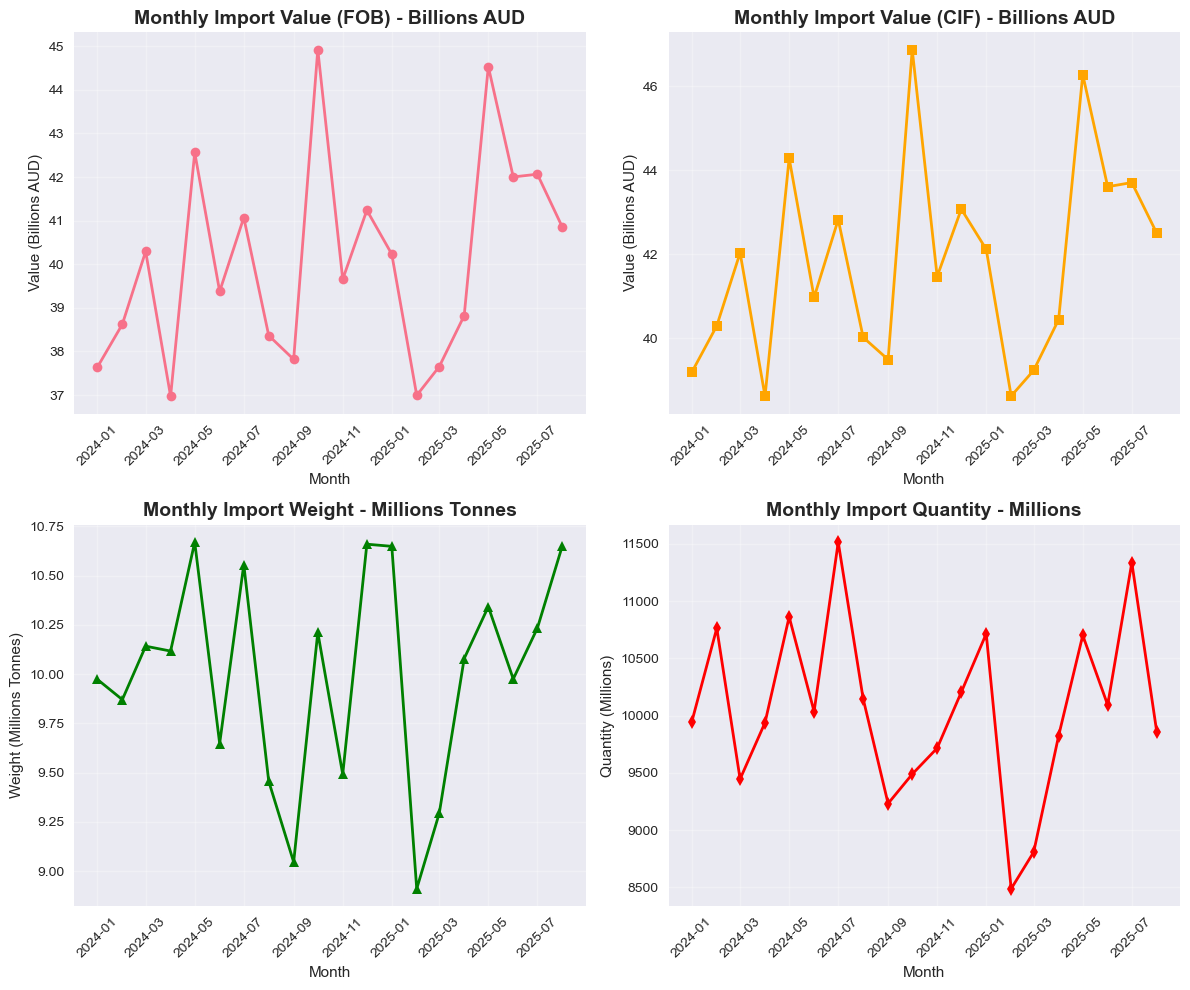


✅ Monthly trend charts created


In [50]:
# Plot monthly trends
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Monthly FOB Value
axes[0, 0].plot(monthly_stats['date'], monthly_stats['valuefob']/1e9, marker='o', linewidth=2)
axes[0, 0].set_title('Monthly Import Value (FOB) - Billions AUD', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Value (Billions AUD)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Monthly CIF Value
axes[0, 1].plot(monthly_stats['date'], monthly_stats['valuecif']/1e9, marker='s', linewidth=2, color='orange')
axes[0, 1].set_title('Monthly Import Value (CIF) - Billions AUD', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Value (Billions AUD)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# Monthly Weight
axes[1, 0].plot(monthly_stats['date'], monthly_stats['weight']/1e6, marker='^', linewidth=2, color='green')
axes[1, 0].set_title('Monthly Import Weight - Millions Tonnes', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Weight (Millions Tonnes)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# Monthly Quantity
axes[1, 1].plot(monthly_stats['date'], monthly_stats['quantity']/1e6, marker='d', linewidth=2, color='red')
axes[1, 1].set_title('Monthly Import Quantity - Millions', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Quantity (Millions)')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n✅ Monthly trend charts created")


In [51]:
# Year-over-Year comparison
print("=== YEAR-OVER-YEAR COMPARISON ===")

yearly_stats = df.groupby('year').agg({
    'valuefob': 'sum',
    'valuecif': 'sum',
    'weight': 'sum',
    'quantity': 'sum',
    'month': 'nunique'  # Number of months with data
}).reset_index()

print(f"\nYearly Summary:")
print(yearly_stats.to_string(index=False))

# Calculate growth rates
if len(yearly_stats) > 1:
    print(f"\n\n=== GROWTH ANALYSIS ===")
    for col in ['valuefob', 'valuecif', 'weight', 'quantity']:
        if col in yearly_stats.columns:
            values = yearly_stats[col].values
            if len(values) == 2 and values[0] > 0:
                growth = ((values[1] - values[0]) / values[0]) * 100
                print(f"{col.upper()} Growth: {growth:+.2f}%")
                print(f"  {yearly_stats['year'].iloc[0]}: ${values[0]:,.0f}" if 'value' in col else f"  {yearly_stats['year'].iloc[0]}: {values[0]:,.2f}")
                print(f"  {yearly_stats['year'].iloc[1]}: ${values[1]:,.0f}" if 'value' in col else f"  {yearly_stats['year'].iloc[1]}: {values[1]:,.2f}")


=== YEAR-OVER-YEAR COMPARISON ===

Yearly Summary:
 year     valuefob     valuecif       weight     quantity  month
 2024 4.785388e+11 4.991253e+11 1.198366e+08 1.213086e+11     12
 2025 3.231511e+11 3.364928e+11 8.013081e+07 7.983028e+10      8


=== GROWTH ANALYSIS ===
VALUEFOB Growth: -32.47%
  2024: $478,538,847,318
  2025: $323,151,128,627
VALUECIF Growth: -32.58%
  2024: $499,125,283,747
  2025: $336,492,792,347
WEIGHT Growth: -33.13%
  2024: 119,836,578.81
  2025: 80,130,808.64
QUANTITY Growth: -34.19%
  2024: 121,308,641,196.16
  2025: 79,830,281,075.31


## 3. Geographic Analysis
### Top Trading Partners

#### Countries contributing the highest import value

In [52]:
# Top countries by value
print("=== TOP COUNTRIES BY IMPORT VALUE ===")

country_stats = df.groupby('country_description').agg({
    'valuefob': 'sum',
    'valuecif': 'sum',
    'weight': 'sum',
    'quantity': 'sum',
    'month': 'count'  # Number of records
}).reset_index()

country_stats = country_stats.sort_values('valuecif', ascending=False)
country_stats['valuecif_pct'] = (country_stats['valuecif'] / country_stats['valuecif'].sum()) * 100
country_stats['cumulative_pct'] = country_stats['valuecif_pct'].cumsum()

print(f"\nTop 20 Countries by CIF Value:")
print(country_stats.head(20).to_string(index=False))

# Show top 10
top_10_countries = country_stats.head(10)
print(f"\n\nTop 10 Countries represent {top_10_countries['valuecif_pct'].sum():.2f}% of total imports")


=== TOP COUNTRIES BY IMPORT VALUE ===

Top 20 Countries by CIF Value:
                                 country_description     valuefob     valuecif       weight     quantity  month  valuecif_pct  cumulative_pct
                    China (excludes SARs and Taiwan) 1.985368e+11 2.084383e+11 3.836439e+07 3.807312e+10 931539     24.944209       24.944209
                            United States of America 9.687948e+10 1.001782e+11 8.494206e+06 8.077069e+09 536656     11.988520       36.932729
                                               Japan 4.185769e+10 4.365258e+10 1.275805e+07 9.824927e+09 173761      5.223987       42.156716
                          Korea, Republic of (South) 3.931555e+10 4.129356e+10 2.243107e+07 2.394383e+10  76549      4.941679       47.098395
                                            Thailand 3.289057e+10 3.419590e+10 6.136298e+06 4.180129e+09  84004      4.092288       51.190683
                                             Germany 3.214089e+10 3.334929e+10

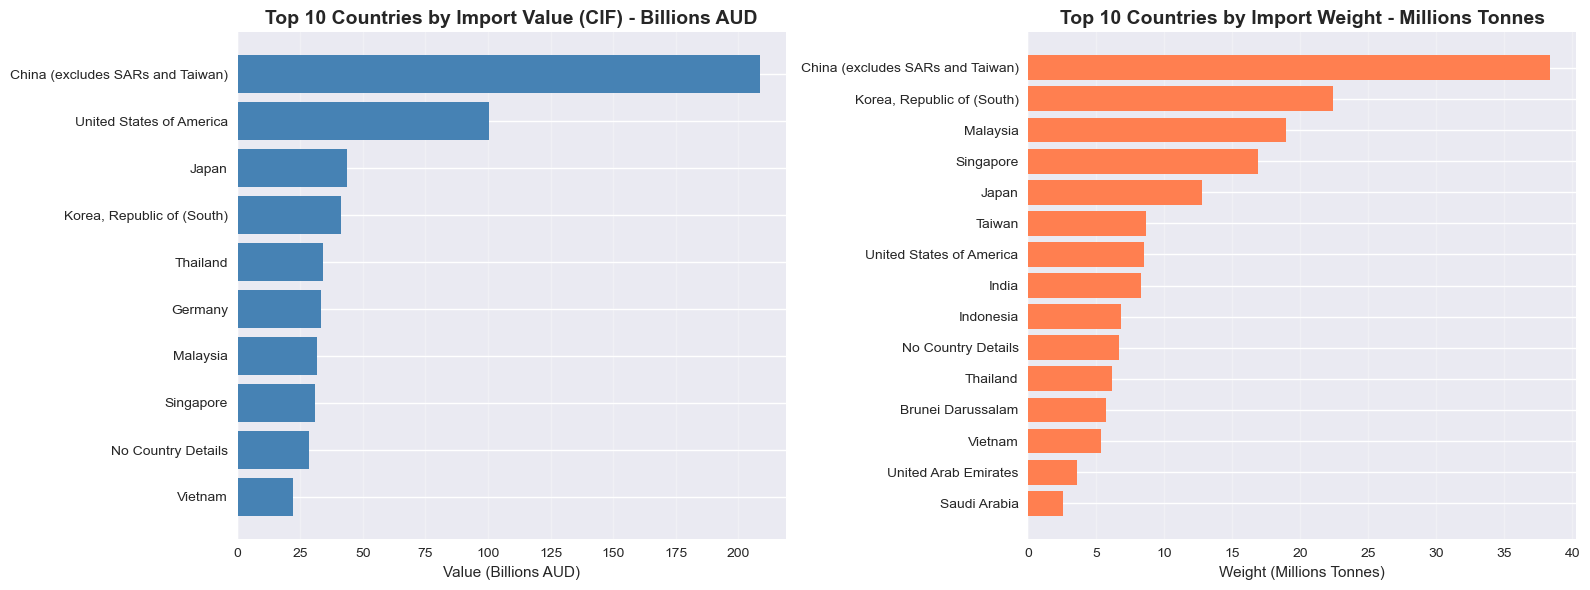

In [53]:
# Visualize top countries
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 15 countries by value (using CIF)
top_10 = country_stats.head(10)
axes[0].barh(top_10['country_description'], top_10['valuecif']/1e9, color='steelblue')
axes[0].set_title('Top 10 Countries by Import Value (CIF) - Billions AUD', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Value (Billions AUD)')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Top 15 countries by weight
country_weight = df.groupby('country_description')['weight'].sum().sort_values(ascending=False).head(15)
axes[1].barh(country_weight.index, country_weight.values/1e6, color='coral')
axes[1].set_title('Top 10 Countries by Import Weight - Millions Tonnes', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Weight (Millions Tonnes)')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


## Imports by Australian Port

### Total CIF value by port

### Total tonnes by port

=== PORT ANALYSIS ===

Top 10 Australian Ports by Value (CIF):
ausport_description     valuefob     valuecif       weight   month
             Sydney 2.550303e+11 2.640596e+11 3.557098e+07 1750727
          Melbourne 1.950189e+11 2.032638e+11 2.805386e+07 1311883
           Brisbane 1.001470e+11 1.048057e+11 2.962414e+07  564171
          Fremantle 5.444311e+10 5.710544e+10 2.326660e+07  238737
    Conf Aust Ports 5.221665e+10 5.432825e+10 1.113033e+07  156647
        Port Kembla 2.809217e+10 2.932388e+10 6.453721e+06    4881
      Port Adelaide 1.869013e+10 1.969220e+10 8.557064e+06  104023
              Perth 1.717121e+10 1.759255e+10 1.235150e+05  242531
            Geelong 1.448415e+10 1.546099e+10 1.531762e+07     738
          Newcastle 7.960587e+09 8.507294e+09 6.955267e+06    1008


Top 10 Origin Ports by Value (CIF):
                         osport_description     valuefob     valuecif       weight  month
                                   Shanghai 7.166886e+10 7.490069e+10 7.

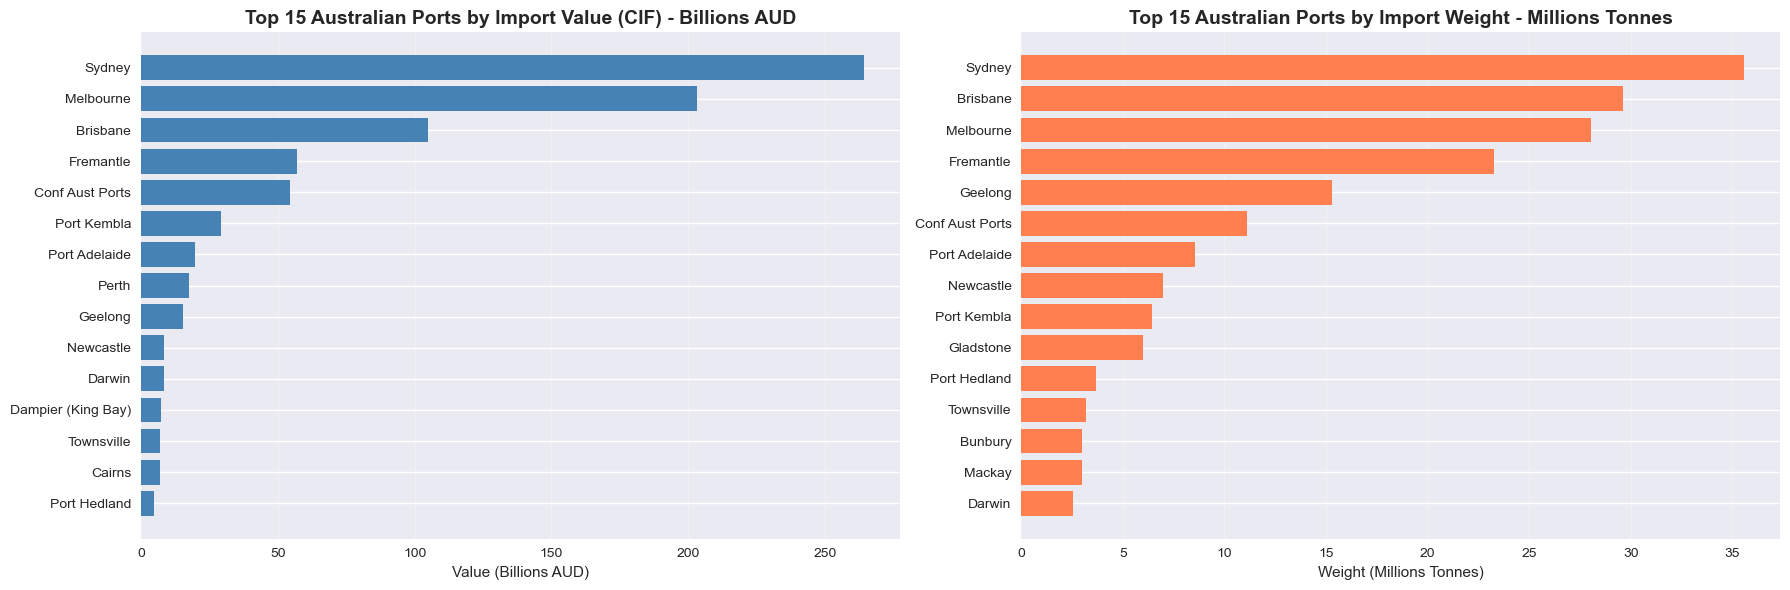

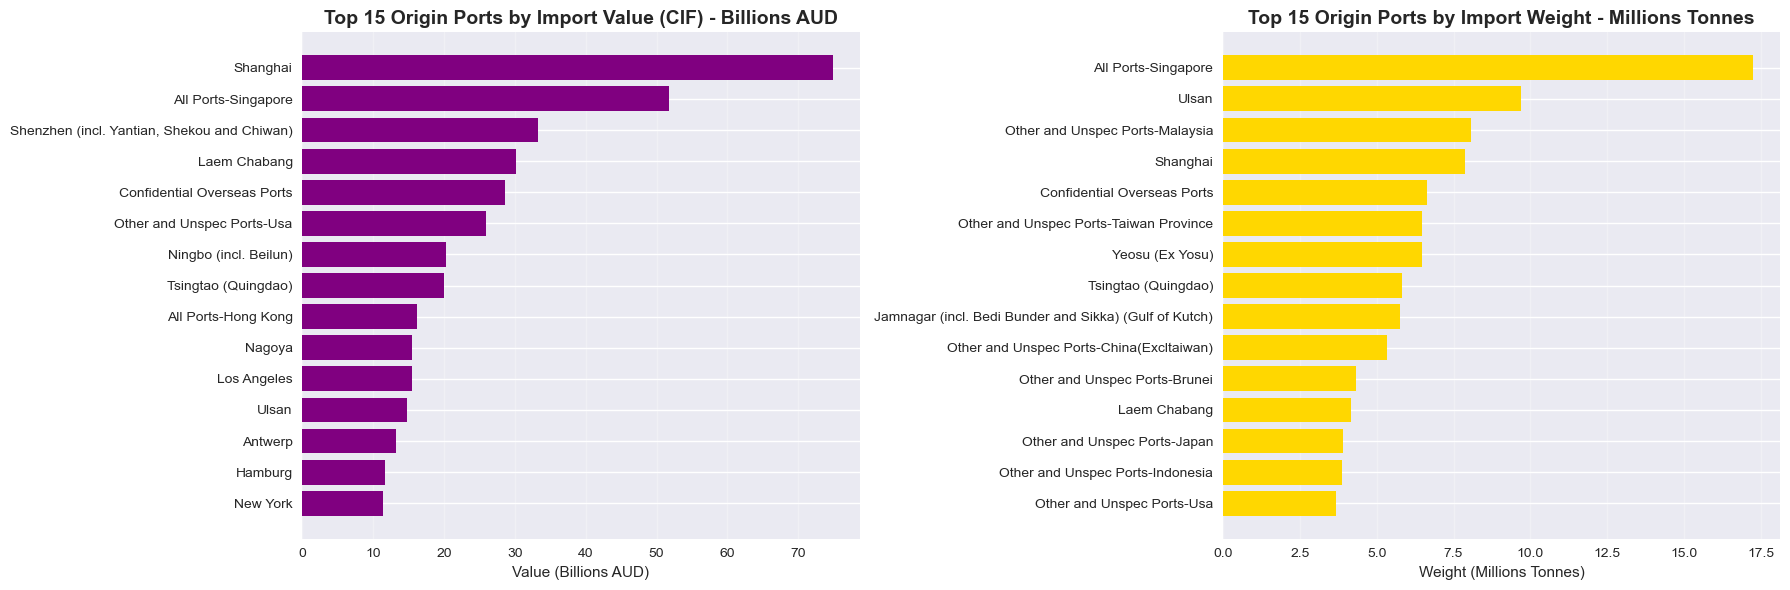


Port analysis visualization complete


In [54]:
# Port analysis
print("=== PORT ANALYSIS ===")

# Australian ports
ausport_stats = df.groupby('ausport_description').agg({
    'valuefob': 'sum',
    'valuecif': 'sum',
    'weight': 'sum',
    'month': 'count'
}).reset_index().sort_values('valuecif', ascending=False)

print(f"\nTop 10 Australian Ports by Value (CIF):")
print(ausport_stats.head(10).to_string(index=False))

# Origin ports
osport_stats = df.groupby('osport_description').agg({
    'valuefob': 'sum',
    'valuecif': 'sum',
    'weight': 'sum',
    'month': 'count'
}).reset_index().sort_values('valuecif', ascending=False)

print(f"\n\nTop 10 Origin Ports by Value (CIF):")
print(osport_stats.head(10).to_string(index=False))

# Visualize Australian ports
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Top 15 Australian ports by CIF value
top_15_ausports = ausport_stats.head(15)
axes[0].barh(top_15_ausports['ausport_description'], top_15_ausports['valuecif']/1e9, color='steelblue')
axes[0].set_title('Top 15 Australian Ports by Import Value (CIF) - Billions AUD', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Value (Billions AUD)')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Top 15 Australian ports by weight
ausport_weight = df.groupby('ausport_description')['weight'].sum().sort_values(ascending=False).head(15)
axes[1].barh(ausport_weight.index, ausport_weight.values/1e6, color='coral')
axes[1].set_title('Top 15 Australian Ports by Import Weight - Millions Tonnes', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Weight (Millions Tonnes)')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Visualize Origin ports
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Top 15 Origin ports by CIF value
top_15_osports = osport_stats.head(15)
axes[0].barh(top_15_osports['osport_description'], top_15_osports['valuecif']/1e9, color='purple')
axes[0].set_title('Top 15 Origin Ports by Import Value (CIF) - Billions AUD', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Value (Billions AUD)')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Top 15 Origin ports by weight
osport_weight = df.groupby('osport_description')['weight'].sum().sort_values(ascending=False).head(15)
axes[1].barh(osport_weight.index, osport_weight.values/1e6, color='gold')
axes[1].set_title('Top 15 Origin Ports by Import Weight - Millions Tonnes', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Weight (Millions Tonnes)')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"\nPort analysis visualization complete")


In [55]:
# Create Port-Country Matrix for analysis
print("=== CREATING PORT-COUNTRY MATRIX ===\n")

# Get top ports and countries (reuse from earlier analysis if available, otherwise recalculate)
if 'ausport_stats' not in locals() and 'ausport_stats' not in globals():
    ausport_stats = df.groupby('ausport_description').agg({
        'valuecif': 'sum'
    }).reset_index().sort_values('valuecif', ascending=False)

if 'country_stats' not in locals() and 'country_stats' not in globals():
    country_stats = df.groupby('country_description').agg({
        'valuecif': 'sum'
    }).reset_index().sort_values('valuecif', ascending=False)

# Get top ports and countries
top_10_ports = ausport_stats.head(10)['ausport_description'].tolist()
top_15_countries = country_stats.head(15)['country_description'].tolist()

# Filter data to top ports and countries
port_country_data = df[
    (df['ausport_description'].isin(top_10_ports)) & 
    (df['country_description'].isin(top_15_countries))
].copy()

# Aggregate by port and country
port_country_matrix = port_country_data.groupby(['ausport_description', 'country_description']).agg({
    'valuecif': 'sum'
}).reset_index()

# Calculate percentage of each port's total for each country
port_totals = port_country_matrix.groupby('ausport_description')['valuecif'].transform('sum')
port_country_matrix['pct_of_port'] = (port_country_matrix['valuecif'] / port_totals * 100).round(2)

# Sort by port and value for better organization
port_country_matrix = port_country_matrix.sort_values(['ausport_description', 'valuecif'], ascending=[True, False])

# Create pivot table for heatmap (in billions)
port_country_pivot = port_country_matrix.pivot_table(
    index='ausport_description',
    columns='country_description',
    values='valuecif',
    fill_value=0
)

# Convert to billions for readability
port_country_pivot_billions = port_country_pivot / 1e9

print(f"Created matrix with {len(top_10_ports)} ports and {len(top_15_countries)} countries")
print(f"Matrix shape: {port_country_pivot_billions.shape}")
print("✅ Port-Country matrix created successfully")
print("="*80)


=== CREATING PORT-COUNTRY MATRIX ===

Created matrix with 10 ports and 15 countries
Matrix shape: (10, 15)
✅ Port-Country matrix created successfully



=== PORT-COUNTRY MATRIX HEATMAP ===



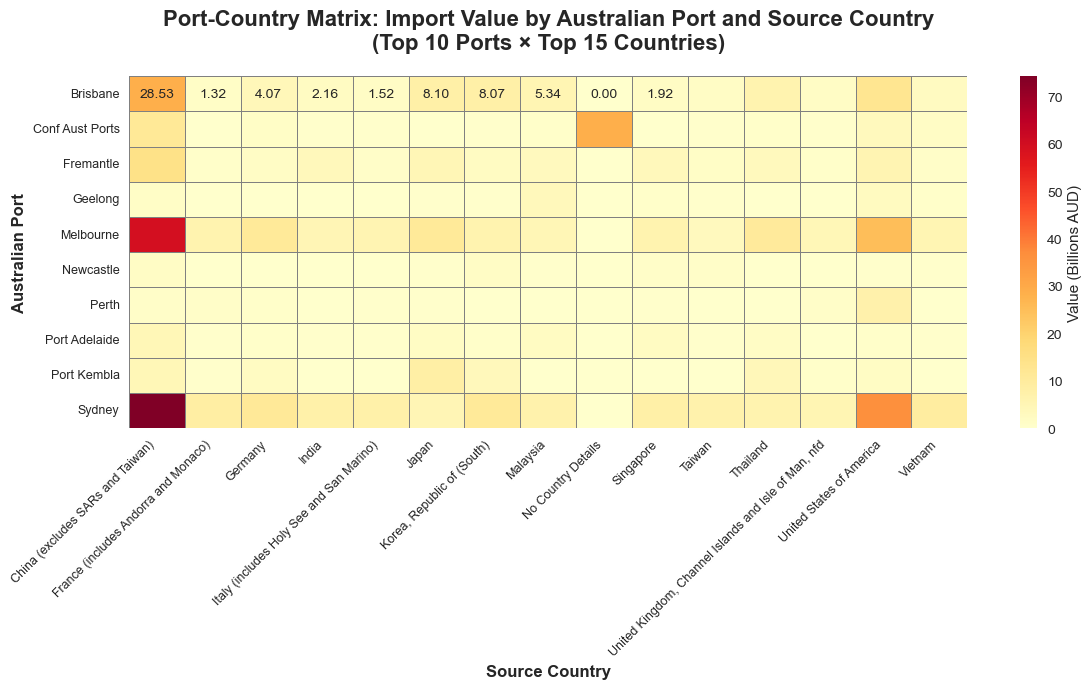

Port-Country Matrix heatmap visualization complete


In [56]:
# Visualize Port-Country Matrix as Heatmap
print("\n=== PORT-COUNTRY MATRIX HEATMAP ===\n")

fig, ax = plt.subplots(figsize=(12, 7))

# Create heatmap
sns.heatmap(port_country_pivot_billions, 
            annot=True, 
            fmt='.2f', 
            cmap='YlOrRd',
            cbar_kws={'label': 'Value (Billions AUD)'},
            linewidths=0.5,
            linecolor='gray',
            ax=ax)

ax.set_title('Port-Country Matrix: Import Value by Australian Port and Source Country\n(Top 10 Ports × Top 15 Countries)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Source Country', fontsize=12, fontweight='bold')
ax.set_ylabel('Australian Port', fontsize=12, fontweight='bold')

# Rotate labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)

plt.tight_layout()
plt.show()

print("Port-Country Matrix heatmap visualization complete")



=== VISUALIZING COUNTRY CONCENTRATION ===



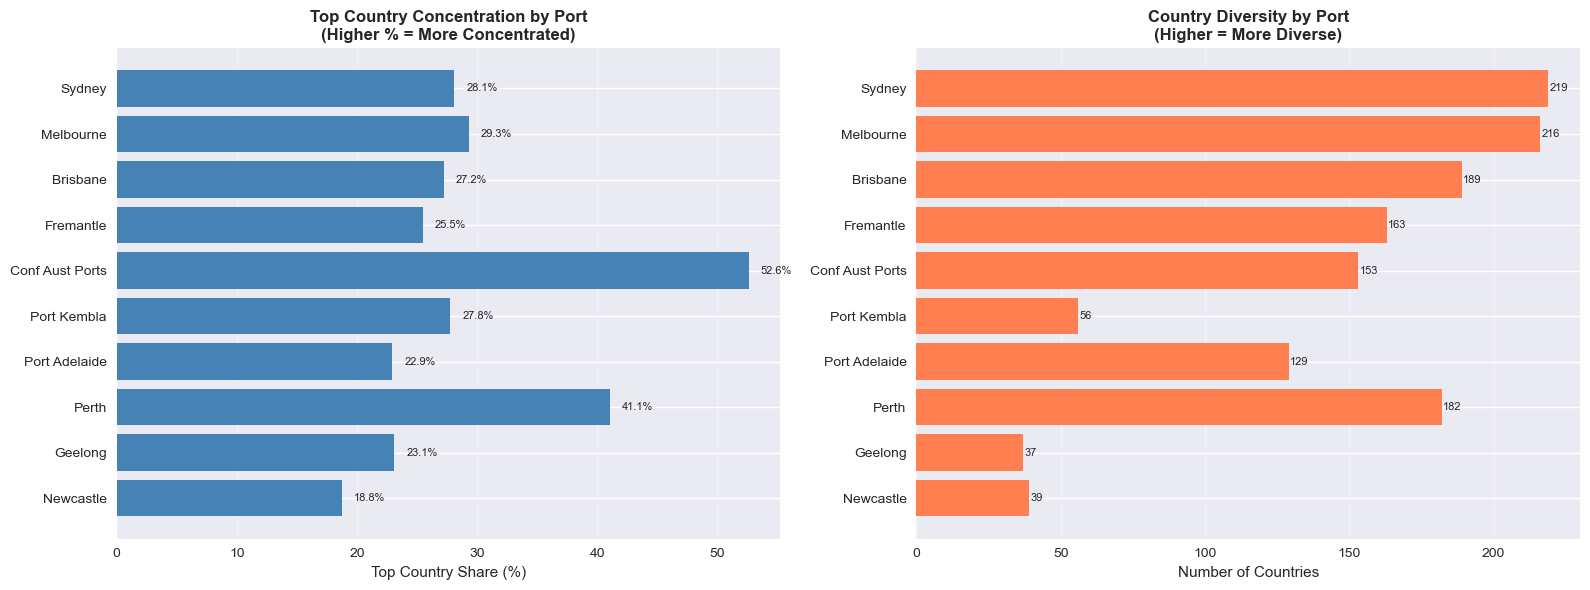

✅ Country concentration visualization complete


In [57]:
# Visualize country concentration by port
print("\n=== VISUALIZING COUNTRY CONCENTRATION ===\n")

# Create port_country_matrix for ALL ports and ALL countries (not filtered)
# This ensures accurate concentration and diversity metrics
port_country_matrix_full = df.groupby(['ausport_description', 'country_description']).agg({
    'valuecif': 'sum'
}).reset_index()

# Calculate percentage of each country for each port using transform
port_totals = port_country_matrix_full.groupby('ausport_description')['valuecif'].transform('sum')
port_country_matrix_full['pct_of_port'] = (port_country_matrix_full['valuecif'] / port_totals * 100).round(2)

# Create the port_concentration dataframe
# Use 'nunique' to count UNIQUE countries, not row count
# Use 'max' to get top country percentage (no order-dependent iloc[0])
port_concentration = port_country_matrix_full.groupby('ausport_description').agg({
    'valuecif': 'sum',
    'country_description': 'nunique',  # Count unique countries, not rows
    'pct_of_port': 'max'  # Maximum percentage = top country share
}).reset_index()
port_concentration.columns = ['port', 'total_value', 'num_countries', 'top_country_pct']

# Sort by total value to get top ports
port_concentration = port_concentration.sort_values('total_value', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Chart 1: Top country percentage by port (Concentration)
top_10_ports_concentration = port_concentration.head(10)
axes[0].barh(top_10_ports_concentration['port'], top_10_ports_concentration['top_country_pct'], color='steelblue')
axes[0].set_xlabel('Top Country Share (%)', fontsize=11)
axes[0].set_title('Top Country Concentration by Port\n(Higher % = More Concentrated)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].invert_yaxis()

# Add value labels
for i, (idx, row) in enumerate(top_10_ports_concentration.iterrows()):
    axes[0].text(row['top_country_pct'] + 1, i, f"{row['top_country_pct']:.1f}%",
                va='center', fontsize=8)

# Chart 2: Number of countries per port (Diversity)
axes[1].barh(top_10_ports_concentration['port'], top_10_ports_concentration['num_countries'], color='coral')
axes[1].set_xlabel('Number of Countries', fontsize=11)
axes[1].set_title('Country Diversity by Port\n(Higher = More Diverse)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].invert_yaxis()

# Add value labels
for i, (idx, row) in enumerate(top_10_ports_concentration.iterrows()):
    axes[1].text(row['num_countries'] + 0.5, i, f"{int(row['num_countries'])}",
                va='center', fontsize=8)

plt.tight_layout()
plt.show()

print("✅ Country concentration visualization complete")


#### **Understanding Port Specialization: Concentration vs. Diversity**

**What These Charts Tell Us:**

**Chart 1: Top Country Concentration (Left - Blue Bars)**
- **What it measures:** How much of each port's imports come from its single largest supplier country
- **Why it matters:** High concentration = higher risk if that country faces trade disruptions, tariffs, or economic issues
- **Example:** "Conf Aust Ports" at 52.6% means over half of its imports come from one country - making it vulnerable to supply chain disruptions from that country

**Chart 2: Country Diversity (Right - Orange Bars)**
- **What it measures:** How many different countries each port trades with
- **Why it matters:** More countries = more resilience and flexibility in sourcing
- **Example:** Sydney trades with 219 countries, giving it many alternative sources if one country has issues

**Key Insights for Decision-Making:**

1. **High Concentration + Low Diversity = HIGH RISK** 
   - Example: "Conf Aust Ports" (52.6% concentration, 153 countries)
   - **Action:** Consider diversifying sources to reduce dependency

2. **Low Concentration + High Diversity = LOW RISK** 
   - Example: Sydney (28.1% concentration, 219 countries)
   - **Status:** Well-diversified, resilient supply chain

3. **Moderate Concentration + High Diversity = BALANCED** 
   - Example: Melbourne (29.3% concentration, 216 countries)
   - **Status:** Has a dominant partner but maintains flexibility

**Business Recommendations:**
- Ports with >40% concentration should develop contingency plans
- Ports with <30 countries should explore new trade relationships
- Use this data to identify supply chain vulnerabilities and opportunities

=== STATE ANALYSIS ===

State Summary:
                       state     valuefob     valuecif       weight   month  valuecif_pct
             New South Wales 2.825158e+11 2.929389e+11 4.829925e+07 1583377     35.056553
                    Victoria 2.106527e+11 2.199700e+11 4.544161e+07 1315141     26.324232
                  Queensland 1.287168e+11 1.347443e+11 4.358057e+07  690665     16.125108
           Western Australia 9.138627e+10 9.564878e+10 3.621247e+07  518314     11.446471
            No state details 5.221665e+10 5.432825e+10 1.113033e+07  156647      6.501564
             South Australia 2.418015e+10 2.547544e+10 1.053662e+07  186372      3.048695
          Northern Territory 8.554867e+09 8.833498e+09 2.675999e+06   20584      1.057121
                    Tasmania 3.340445e+09 3.551814e+09 2.090275e+06   10172      0.425052
Australian Capital Territory 1.263037e+08 1.270422e+08 2.667418e+02     307      0.015203


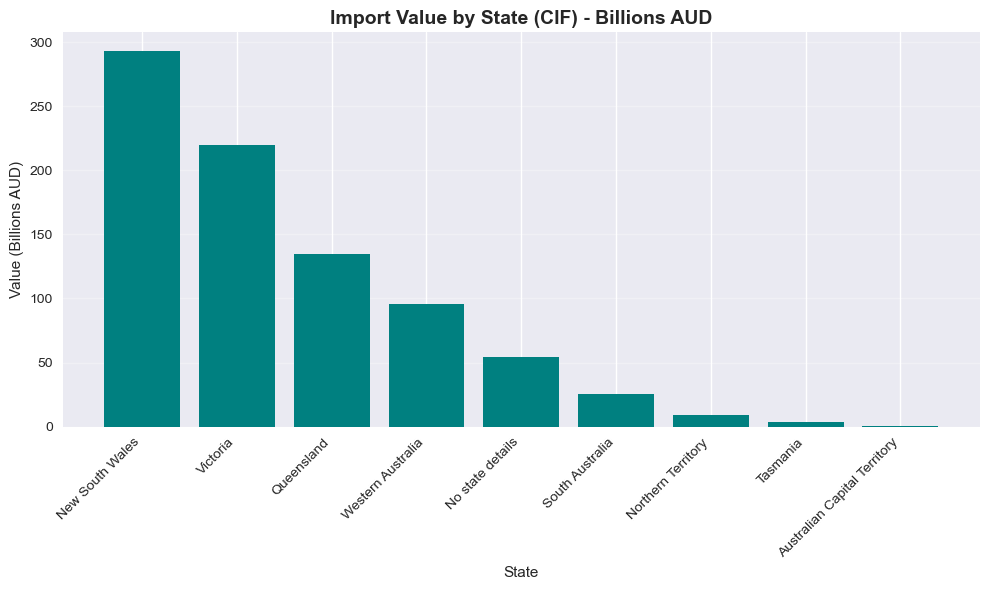


State analysis visualization complete


In [58]:
# State analysis
print("=== STATE ANALYSIS ===")

state_stats = df.groupby('state').agg({
    'valuefob': 'sum',
    'valuecif': 'sum',
    'weight': 'sum',
    'month': 'count'
}).reset_index().sort_values('valuecif', ascending=False)

state_stats['valuecif_pct'] = (state_stats['valuecif'] / state_stats['valuecif'].sum()) * 100

print(f"\nState Summary:")
print(state_stats.to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))

# Bar chart by CIF value
plt.bar(state_stats['state'], state_stats['valuecif']/1e9, color='teal')
plt.title('Import Value by State (CIF) - Billions AUD', fontsize=14, fontweight='bold')
plt.xlabel('State')
plt.ylabel('Value (Billions AUD)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"\nState analysis visualization complete")


## 4. Commodity Analysis

### Top Imported Commodities

#### Rank by CIF value

#### Rank by weight


In [59]:
# Top commodities by value
print("=== TOP COMMODITIES ===")

# Check if df is loaded
if 'df' not in locals() and 'df' not in globals():
    print("Error: DataFrame 'df' not found. Please run the data loading cells first.")
else:
    try:
        commodity_stats = df.groupby('commodity_description').agg({
            'valuefob': 'sum',
            'valuecif': 'sum',
            'weight': 'sum',
            'quantity': 'sum',
            'month': 'count'
        }).reset_index().sort_values('valuecif', ascending=False)

        commodity_stats['valuecif_pct'] = (commodity_stats['valuecif'] / commodity_stats['valuecif'].sum()) * 100
        commodity_stats['cumulative_pct'] = commodity_stats['valuecif_pct'].cumsum()

        print(f"\nTop 15 Commodities by Value (CIF):")
        # Truncate long commodity descriptions for display
        commodity_display = commodity_stats.head(15).copy()
        commodity_display['commodity_description'] = commodity_display['commodity_description'].str[:70] + '...'
        print(commodity_display[['commodity_description', 'valuefob', 'valuecif', 'valuecif_pct']].to_string(index=False))
        print(f"\n(Note: Commodity descriptions truncated to 70 characters for display)")

        print(f"\n\nTop 10 Commodities represent {commodity_stats.head(10)['valuecif_pct'].sum():.2f}% of total imports (by CIF value)")
    except Exception as e:
        print(f"Error: {e}")
        print(f"\nAvailable columns: {df.columns.tolist() if 'df' in locals() or 'df' in globals() else 'N/A'}")


=== TOP COMMODITIES ===

Top 15 Commodities by Value (CIF):
                                                    commodity_description     valuefob     valuecif  valuecif_pct
Petroleum oils & oils obtained from bituminous minerals (excl. crude) ... 7.612365e+10 7.975528e+10      9.544466
Motor vehicles for the transport of persons (excl. for the transport o... 5.844812e+10 6.055192e+10      7.246364
        Commodities and transactions not included in Merchandise Trade... 4.178306e+10 4.209834e+10      5.037988
Combined confidential items excluding some of SITC 28099 (exports only... 3.840221e+10 4.040565e+10      4.835421
Motor vehicles for the transport of goods (excl. off highway dumpers) ... 2.276596e+10 2.378958e+10      2.846945
Non-monetary gold (incl. gold plated with platinum) unwrought or in se... 2.195075e+10 2.198752e+10      2.631289
Medicaments (excl. those containing antibiotics, hormones & alkaloids ... 1.305500e+10 1.334943e+10      1.597552
      Petroleum oils and oil

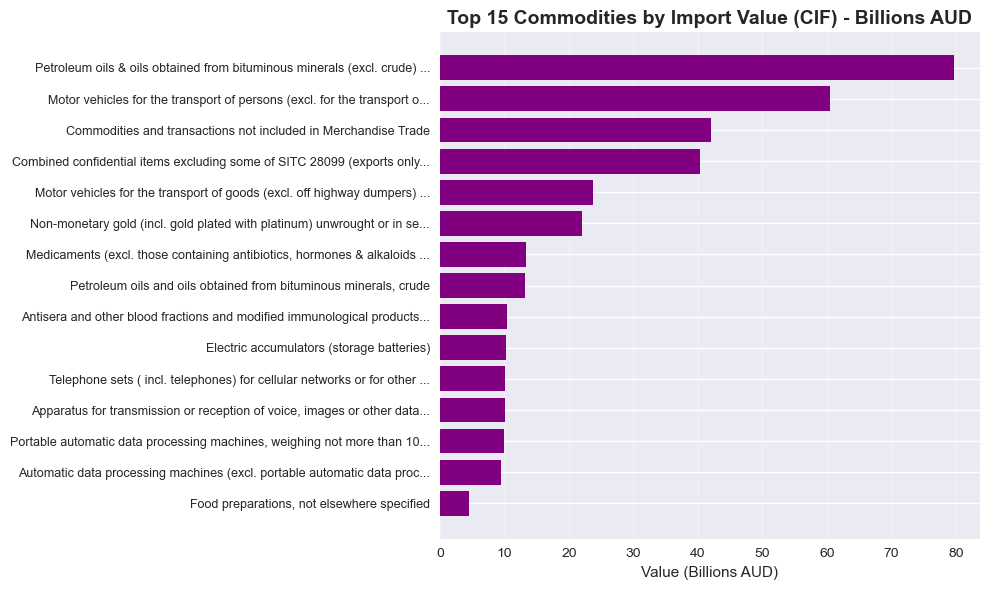

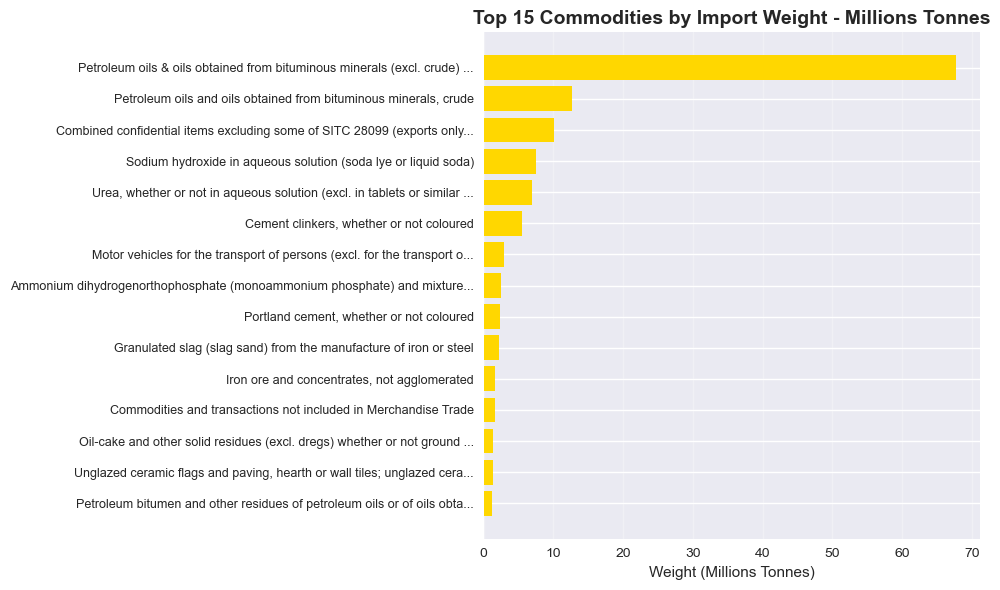

In [60]:
# Visualize top commodities - Individual charts

# Chart 1: Top 15 commodities by value
top_15_comm = commodity_stats.head(15)
top_15_comm_labels = [desc[:70] + '...' if len(desc) > 70 else desc
                       for desc in top_15_comm['commodity_description']]

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_15_comm)), top_15_comm['valuecif']/1e9, color='purple')
plt.title('Top 15 Commodities by Import Value (CIF) - Billions AUD', fontsize=14, fontweight='bold')
plt.xlabel('Value (Billions AUD)')
plt.yticks(range(len(top_15_comm)), top_15_comm_labels, fontsize=9)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Chart 2: Top 15 commodities by weight
commodity_weight = df.groupby('commodity_description')['weight'].sum().sort_values(ascending=False).head(15)
commodity_weight_labels = [desc[:70] + '...' if len(desc) > 70 else desc        
                           for desc in commodity_weight.index]

plt.figure(figsize=(10, 6))
plt.barh(range(len(commodity_weight)), commodity_weight.values/1e6, color='gold')
plt.title('Top 15 Commodities by Import Weight - Millions Tonnes', fontsize=14, fontweight='bold')
plt.xlabel('Weight (Millions Tonnes)')
plt.yticks(range(len(commodity_weight)), commodity_weight_labels, fontsize=9)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


=== CIF vs FOB COMPARISON FOR TOP 10 COMMODITIES ===



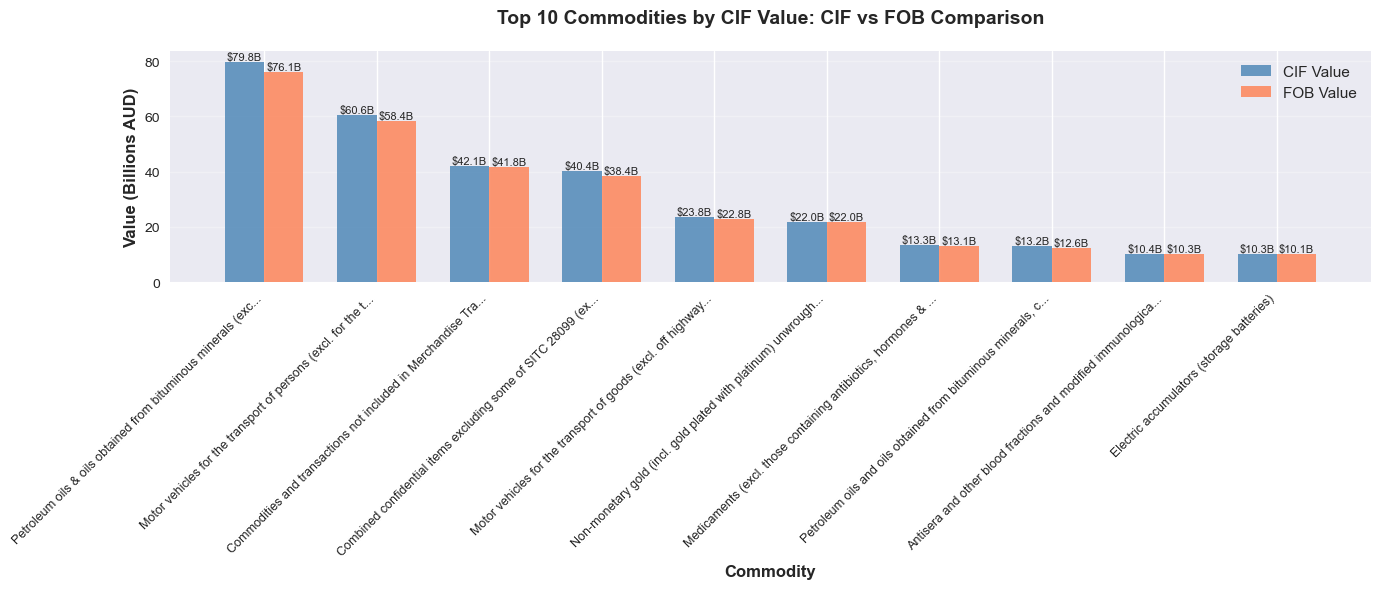


Summary:
  Total CIF Value (Top 10): $315.84 billion
  Total FOB Value (Top 10): $305.40 billion
  Average Difference (CIF - FOB): $10.45 billion
  Average % Difference: 3.42%


In [61]:
# Grouped bar chart: Top 10 commodities by CIF value - comparing CIF vs FOB
print("=== CIF vs FOB COMPARISON FOR TOP 10 COMMODITIES ===\n")

# Get top 10 commodities ranked by CIF value
top_10_comm = commodity_stats.head(10).copy()

# Truncate commodity names for better display
top_10_labels = [desc[:60] + '...' if len(desc) > 60 else desc 
                 for desc in top_10_comm['commodity_description']]

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(top_10_comm))
width = 0.35  # Width of the bars

# Create bars for CIF and FOB
bars1 = ax.bar(x - width/2, top_10_comm['valuecif']/1e9, width, 
               label='CIF Value', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, top_10_comm['valuefob']/1e9, width, 
               label='FOB Value', color='coral', alpha=0.8)

# Customize the chart
ax.set_xlabel('Commodity', fontsize=12, fontweight='bold')
ax.set_ylabel('Value (Billions AUD)', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Commodities by CIF Value: CIF vs FOB Comparison', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(top_10_labels, rotation=45, ha='right', fontsize=9)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0.5:  # Only label if value is significant
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'${height:.1f}B',
                   ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary:")
print(f"  Total CIF Value (Top 10): ${top_10_comm['valuecif'].sum()/1e9:.2f} billion")
print(f"  Total FOB Value (Top 10): ${top_10_comm['valuefob'].sum()/1e9:.2f} billion")
print(f"  Average Difference (CIF - FOB): ${(top_10_comm['valuecif'].sum() - top_10_comm['valuefob'].sum())/1e9:.2f} billion")
print(f"  Average % Difference: {((top_10_comm['valuecif'].sum() - top_10_comm['valuefob'].sum()) / top_10_comm['valuefob'].sum() * 100):.2f}%")


##### What insight does this chart give to stakeholders?

#####🔹 Which commodities dominate import value
#####🔹 The gap between CIF and FOB

#####→ showing freight + insurance cost

#####🔹 Whether certain commodities have unusually high shipping costs
#####🔹 How cost structure differs across commodity classes

### SITC-Based Industry Analysis
**Hybrid Approach:**
- Uses SITC Sections (0-9) as primary industry groups
- Breaks down Section 6 (Manufactured Goods) by SITC Divisions (2-digit) for better insights
- Provides international comparability while maintaining interpretability


In [62]:
# Analyze major economic sectors from commodity data using commodity_code mapping
print("=== MAJOR ECONOMIC & INDUSTRIAL SECTORS ===")
print("\n" + "="*60)

# Reload module to get latest changes
import importlib
import commodity_code_mapping
importlib.reload(commodity_code_mapping)

# Import SITC-based industry mapping (Hybrid approach)
# Uses SITC Sections (0-9) with Section 6 broken down by divisions
from commodity_code_mapping import map_commodity_code_to_sitc_industry

# Add industry sector to dataframe based on commodity_code
print("Mapping commodity codes to SITC-based industries...")
print("(Using SITC Sections, with Section 6 broken down by divisions)")
df['industry_sector'] = df['commodity_code'].apply(map_commodity_code_to_sitc_industry)

# Aggregate by industry sector
sector_analysis = df.groupby('industry_sector').agg({
    'valuefob': 'sum',
    'valuecif': 'sum',
    'weight': 'sum',
    'commodity_description': 'count'
}).reset_index()

sector_analysis.columns = ['sector', 'valuefob', 'valuecif', 'weight', 'count']

# Calculate totals
total_fob = df['valuecif'].sum()

# Sort by FOB value
sector_analysis = sector_analysis.sort_values('valuecif', ascending=False)
sector_analysis['valuecif_pct'] = (sector_analysis['valuecif'] / total_fob) * 100
sector_analysis['valuecif_billions'] = sector_analysis['valuecif'] / 1e9

# Get top commodity for each sector
sector_analysis['top_commodity'] = ''
for sector in sector_analysis['sector']:
    sector_data = df[df['industry_sector'] == sector]
    if len(sector_data) > 0:
        top_comm = sector_data.groupby('commodity_description')['valuecif'].sum().sort_values(ascending=False).index[0]
        sector_analysis.loc[sector_analysis['sector'] == sector, 'top_commodity'] = top_comm

# Create sector_df for compatibility with visualization
sector_df = sector_analysis.set_index('sector')[['valuecif', 'valuecif_pct', 'valuecif_billions', 'weight', 'count', 'top_commodity']]

print("\nSITC-Based Industries by Import Value (CIF):")
print("(Sections 0-9, with Section 6 broken down by divisions)")
print("-" * 60)
for sector, row in sector_df.iterrows():
    print(f"\n{sector}:")
    print(f"  Total Value: ${row['valuecif_billions']:.2f} billion ({row['valuecif_pct']:.2f}% of total)")
    print(f"  Total Weight: {row['weight']/1e6:.2f} million tonnes")
    print(f"  Number of Commodities: {int(row['count']):,}")
    print(f"  Top Commodity: {row['top_commodity'][:80]}...")

print("\n" + "="*60)
print(f"\nTop 5 Industries represent {sector_df.head(5)['valuecif_pct'].sum():.2f}% of total imports")


=== MAJOR ECONOMIC & INDUSTRIAL SECTORS ===

Mapping commodity codes to SITC-based industries...
(Using SITC Sections, with Section 6 broken down by divisions)

SITC-Based Industries by Import Value (CIF):
(Sections 0-9, with Section 6 broken down by divisions)
------------------------------------------------------------

Non-Ferrous Metals:
  Total Value: $228.94 billion (27.40% of total)
  Total Weight: 10.83 million tonnes
  Number of Commodities: 1,029,158
  Top Commodity: Motor vehicles for the transport of persons (excl. for the transport of ten or m...

Commodities Not Classified Elsewhere:
  Total Value: $128.98 billion (15.44% of total)
  Total Weight: 13.59 million tonnes
  Number of Commodities: 295,449
  Top Commodity: Commodities and transactions not included in Merchandise Trade...

Chemicals & Related Products:
  Total Value: $104.81 billion (12.54% of total)
  Total Weight: 89.01 million tonnes
  Number of Commodities: 55,093
  Top Commodity: Petroleum oils & oils obtai

### Analysis by SITC Section (First Digit)


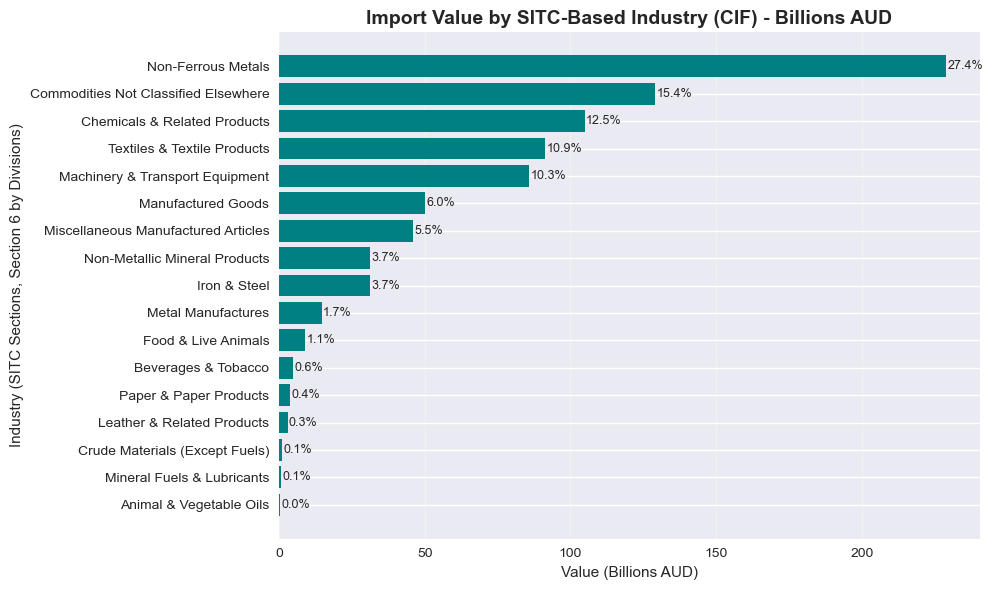


 SITC-based industry analysis visualization complete


In [63]:
# Visualize SITC-based industry analysis
plt.figure(figsize=(10, 6))

# Bar chart of industries by value
sector_df_sorted = sector_df.sort_values('valuecif_billions', ascending=True)   
plt.barh(sector_df_sorted.index, sector_df_sorted['valuecif_billions'], color='teal')
plt.title('Import Value by SITC-Based Industry (CIF) - Billions AUD', fontsize=14, fontweight='bold')
plt.xlabel('Value (Billions AUD)')
plt.ylabel('Industry (SITC Sections, Section 6 by Divisions)')
plt.grid(True, alpha=0.3, axis='x')

# Add percentage labels
for i, (sector, row) in enumerate(sector_df_sorted.iterrows()):
    plt.text(row['valuecif_billions'] + 0.5, i, f"{row['valuecif_pct']:.1f}%",  
             va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n SITC-based industry analysis visualization complete")


## 5.5 Value vs Value Analysis: Market Leaders & Premium Products

### Identifying Market Leaders and Premium Products

Analyzing products and industries by comparing total value with value per unit metrics to identify:
- **Market Leaders**: High total value products (volume leaders)
- **Premium Products**: High value per unit/weight products (premium pricing)


In [64]:
# Industry-Level Value vs Volume Analysis: Market Leaders & Premium Products
print("=== INDUSTRY VALUE VS VOLUME ANALYSIS ===")
print("Identifying Market Leaders (High Volume + High Value) and Premium Products (Low Volume + High Value)\n")
print("="*80)

# Ensure industry_sector column exists
if 'industry_sector' not in df.columns:
    print("Mapping commodities to industries...")
    import importlib
    import commodity_code_mapping
    importlib.reload(commodity_code_mapping)
    from commodity_code_mapping import map_commodity_code_to_sitc_industry
    df['industry_sector'] = df['commodity_code'].apply(map_commodity_code_to_sitc_industry)

# Aggregate by industry sector
industry_analysis = df.groupby('industry_sector').agg({
    'valuecif': 'sum',
    'valuefob': 'sum',
    'weight': 'sum',
    'quantity': 'sum'
}).reset_index()

# Calculate value per tonne (premium indicator)
industry_analysis['value_per_tonne'] = (
    industry_analysis['valuecif'] / industry_analysis['weight'].replace(0, np.nan)
)

# Calculate metrics in billions for easier reading
industry_analysis['total_value_billions'] = industry_analysis['valuecif'] / 1e9
industry_analysis['total_weight_millions'] = industry_analysis['weight'] / 1e6

# Filter out industries with zero weight
industry_analysis = industry_analysis[industry_analysis['weight'] > 0].copy()

# Calculate median values for classification (using median to avoid extreme outliers)
volume_threshold = industry_analysis['total_value_billions'].median()  # Median total value = volume proxy
premium_threshold = industry_analysis['value_per_tonne'].median()  # Median value per tonne = premium threshold

print(f"Classification Thresholds (Median Values):")
print(f"  Volume Threshold (Total Value): ${volume_threshold:.2f} billion")
print(f"  Premium Threshold (Value per Tonne): ${premium_threshold:,.2f} per tonne")
print(f"\n{'='*80}\n")

# Classify industries into quadrants
industry_analysis['category'] = 'Standard'

# Market Leaders: High Volume (total value) AND High Value (total value)
# These are industries with high total value = they have high volume
market_leaders_mask = industry_analysis['total_value_billions'] >= volume_threshold
industry_analysis.loc[market_leaders_mask, 'category'] = 'Market Leader (High Volume + High Value)'

# Premium Products: Low Volume BUT High Value per tonne
# These are industries with lower total value (low volume) but high value per tonne (premium pricing)
premium_mask = (industry_analysis['total_value_billions'] < volume_threshold) & \
               (industry_analysis['value_per_tonne'] >= premium_threshold)
industry_analysis.loc[premium_mask, 'category'] = 'Premium Product (Low Volume + High Value)'

# Sort for display
industry_analysis = industry_analysis.sort_values('total_value_billions', ascending=False)

print(f"Total industries analyzed: {len(industry_analysis)}")
print(f"Market Leaders (High Volume + High Value): {len(industry_analysis[industry_analysis['category'] == 'Market Leader (High Volume + High Value)'])}")
print(f"Premium Products (Low Volume + High Value): {len(industry_analysis[industry_analysis['category'] == 'Premium Product (Low Volume + High Value)'])}")
print(f"\n{'='*80}\n")


=== INDUSTRY VALUE VS VOLUME ANALYSIS ===
Identifying Market Leaders (High Volume + High Value) and Premium Products (Low Volume + High Value)

Classification Thresholds (Median Values):
  Volume Threshold (Total Value): $31.09 billion
  Premium Threshold (Value per Tonne): $4,727.63 per tonne


Total industries analyzed: 17
Market Leaders (High Volume + High Value): 9
Premium Products (Low Volume + High Value): 3




In [65]:
# Market Leaders: High Volume + High Value Industries
print("\n=== MARKET LEADERS: HIGH VOLUME + HIGH VALUE INDUSTRIES ===\n")
print("These industries have high total import value (indicating high volume)\n")
print("They are the market leaders by volume and value\n")

market_leaders_df = industry_analysis[
    industry_analysis['category'] == 'Market Leader (High Volume + High Value)'
].sort_values('total_value_billions', ascending=False).copy()
market_leaders_df['rank'] = range(1, len(market_leaders_df) + 1)

print(f"{'Rank':<6} {'Industry':<50} {'Total Value (B)':<20} {'Value/Tonne':<18} {'Weight (M t)':<15}")
print("-" * 110)

for idx, row in market_leaders_df.iterrows():
    industry_name = row['industry_sector'][:48] + '...' if len(row['industry_sector']) > 50 else row['industry_sector']
    print(f"{row['rank']:<6} {industry_name:<50} ${row['total_value_billions']:>18.2f}  ${row['value_per_tonne']:>16,.0f}  {row['total_weight_millions']:>13.2f}")

print(f"\nTotal Market Leader Industries: {len(market_leaders_df)}")
print(f"Combined Value: ${market_leaders_df['total_value_billions'].sum():.2f} billion")
print(f"Combined Weight: {market_leaders_df['total_weight_millions'].sum():.2f} million tonnes")
print("\n" + "="*80)



=== MARKET LEADERS: HIGH VOLUME + HIGH VALUE INDUSTRIES ===

These industries have high total import value (indicating high volume)

They are the market leaders by volume and value

Rank   Industry                                           Total Value (B)      Value/Tonne        Weight (M t)   
--------------------------------------------------------------------------------------------------------------
1      Non-Ferrous Metals                                 $            228.94  $          21,133          10.83
2      Commodities Not Classified Elsewhere               $            128.98  $           9,491          13.59
3      Chemicals & Related Products                       $            104.81  $           1,178          89.01
4      Textiles & Textile Products                        $             91.24  $           2,640          34.56
5      Machinery & Transport Equipment                    $             85.92  $          21,804           3.94
6      Manufactured Goods       

In [66]:
# Premium Products: Low Volume + High Value Industries
print("\n=== PREMIUM PRODUCTS: LOW VOLUME + HIGH VALUE INDUSTRIES ===\n")
print("These industries have lower total import value (low volume) but high value per tonne (premium pricing)\n")
print("They represent premium, high-value products\n")

premium_df = industry_analysis[
    industry_analysis['category'] == 'Premium Product (Low Volume + High Value)'
].sort_values('value_per_tonne', ascending=False).copy()
premium_df['rank'] = range(1, len(premium_df) + 1)

print(f"{'Rank':<6} {'Industry':<50} {'Value/Tonne':<20} {'Total Value (B)':<18} {'Weight (M t)':<15}")
print("-" * 110)

for idx, row in premium_df.iterrows():
    industry_name = row['industry_sector'][:48] + '...' if len(row['industry_sector']) > 50 else row['industry_sector']
    print(f"{row['rank']:<6} {industry_name:<50} ${row['value_per_tonne']:>18,.0f}  ${row['total_value_billions']:>16.2f}  {row['total_weight_millions']:>13.2f}")

print(f"\nTotal Premium Product Industries: {len(premium_df)}")
print(f"Combined Value: ${premium_df['total_value_billions'].sum():.2f} billion")
print(f"Combined Weight: {premium_df['total_weight_millions'].sum():.2f} million tonnes")
print("\n" + "="*80)



=== PREMIUM PRODUCTS: LOW VOLUME + HIGH VALUE INDUSTRIES ===

These industries have lower total import value (low volume) but high value per tonne (premium pricing)

They represent premium, high-value products

Rank   Industry                                           Value/Tonne          Total Value (B)    Weight (M t)   
--------------------------------------------------------------------------------------------------------------
1      Animal & Vegetable Oils                            $           211,008  $            0.36           0.00
2      Metal Manufactures                                 $             6,022  $           14.59           2.42
3      Paper & Paper Products                             $             4,728  $            3.68           0.78

Total Premium Product Industries: 3
Combined Value: $18.63 billion
Combined Weight: 3.20 million tonnes




=== VALUE VS VOLUME QUADRANT VISUALIZATION ===

Visualizing industries by Total Value (Volume) vs Value per Tonne (Premium)



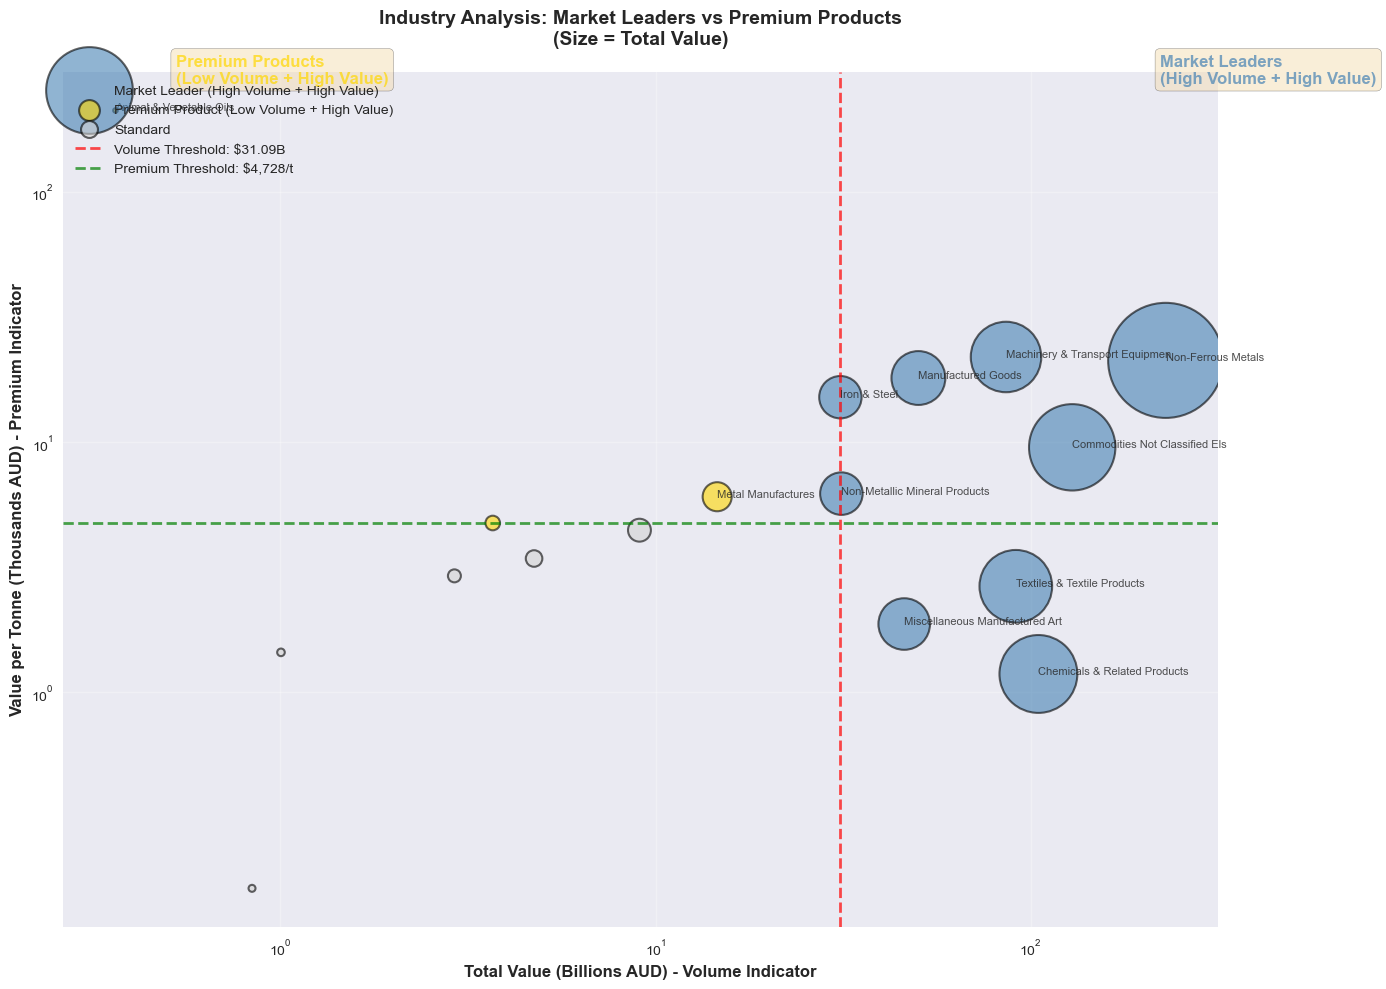

✅ Quadrant visualization complete


In [67]:
# Visualize Value vs Volume Quadrant Analysis
print("\n=== VALUE VS VOLUME QUADRANT VISUALIZATION ===\n")
print("Visualizing industries by Total Value (Volume) vs Value per Tonne (Premium)\n")

fig, ax = plt.subplots(figsize=(14, 10))

# Get the thresholds for plotting reference lines
volume_threshold = industry_analysis['total_value_billions'].median()
premium_threshold = industry_analysis['value_per_tonne'].median()

# Create scatter plot with color coding by category
colors = {'Market Leader (High Volume + High Value)': 'steelblue',
          'Premium Product (Low Volume + High Value)': 'gold',
          'Standard': 'lightgray'}

for category in colors.keys():
    mask = industry_analysis['category'] == category
    if mask.any():
        subset = industry_analysis[mask]
        ax.scatter(subset['total_value_billions'], 
                  subset['value_per_tonne'] / 1000,  # Convert to thousands for readability
                  s=subset['total_value_billions'] * 30,  # Size by total value
                  alpha=0.6, 
                  c=colors[category], 
                  label=category,
                  edgecolors='black', 
                  linewidth=1.5)

# Add reference lines
ax.axvline(x=volume_threshold, color='red', linestyle='--', linewidth=2, alpha=0.7, 
           label=f'Volume Threshold: ${volume_threshold:.2f}B')
ax.axhline(y=premium_threshold/1000, color='green', linestyle='--', linewidth=2, alpha=0.7,
           label=f'Premium Threshold: ${premium_threshold:,.0f}/t')

# Add labels for top industries
for idx, row in industry_analysis.iterrows():
    if row['total_value_billions'] > volume_threshold or row['value_per_tonne'] > premium_threshold:
        ax.annotate(row['industry_sector'][:30], 
                   (row['total_value_billions'], row['value_per_tonne']/1000),
                   fontsize=8, alpha=0.8)

ax.set_xlabel('Total Value (Billions AUD) - Volume Indicator', fontsize=12, fontweight='bold')
ax.set_ylabel('Value per Tonne (Thousands AUD) - Premium Indicator', fontsize=12, fontweight='bold')
ax.set_title('Industry Analysis: Market Leaders vs Premium Products\n(Size = Total Value)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('log')

# Add quadrant labels
ax.text(ax.get_xlim()[1]*0.7, ax.get_ylim()[1]*0.9, 'Market Leaders\n(High Volume + High Value)',
        fontsize=12, fontweight='bold', color='steelblue', alpha=0.7,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.text(ax.get_xlim()[0]*2, ax.get_ylim()[1]*0.9, 'Premium Products\n(Low Volume + High Value)',
        fontsize=12, fontweight='bold', color='gold', alpha=0.7,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("✅ Quadrant visualization complete")
print("="*80)



=== COMPARISON: MARKET LEADERS vs PREMIUM PRODUCTS ===



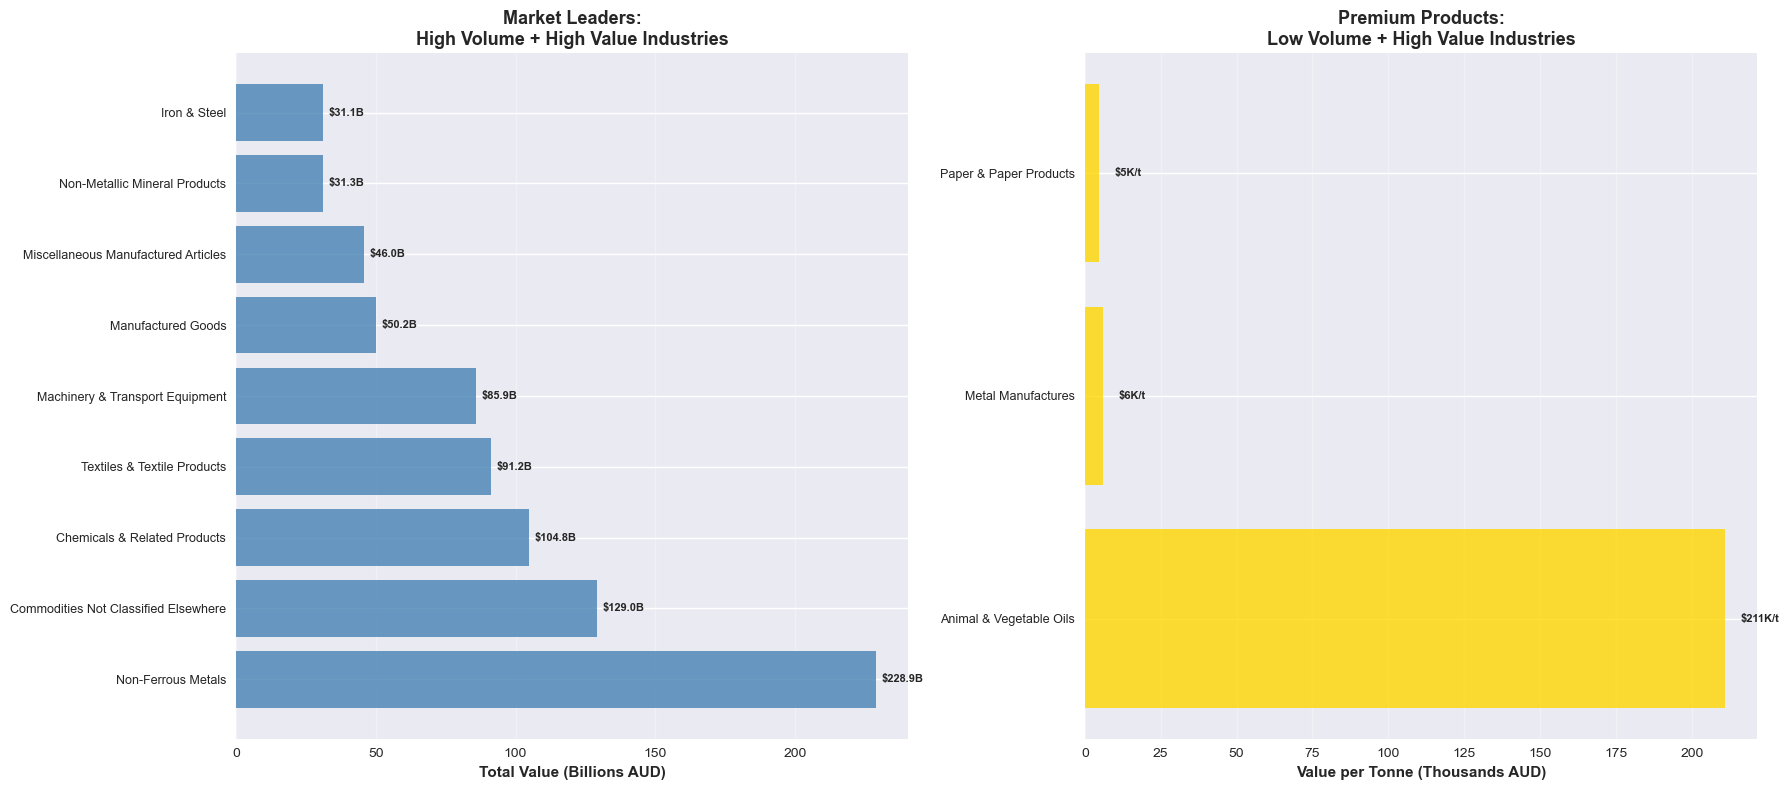

✅ Comparison visualization complete


In [68]:
# Side-by-side comparison: Market Leaders vs Premium Products
print("\n=== COMPARISON: MARKET LEADERS vs PREMIUM PRODUCTS ===\n")

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Chart 1: Market Leaders by Total Value
market_leaders_sorted = market_leaders_df.sort_values('total_value_billions', ascending=True)
leader_labels = [ind[:40] + '...' if len(ind) > 42 else ind 
                 for ind in market_leaders_sorted['industry_sector']]

axes[0].barh(range(len(market_leaders_sorted)), 
             market_leaders_sorted['total_value_billions'], 
             color='steelblue', alpha=0.8)
axes[0].set_yticks(range(len(market_leaders_sorted)))
axes[0].set_yticklabels(leader_labels, fontsize=9)
axes[0].set_xlabel('Total Value (Billions AUD)', fontsize=11, fontweight='bold')
axes[0].set_title('Market Leaders:\nHigh Volume + High Value Industries', 
                  fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].invert_yaxis()

# Add value labels
for i, (idx, row) in enumerate(market_leaders_sorted.iterrows()):
    axes[0].text(row['total_value_billions'] + 2, i, 
                f"${row['total_value_billions']:.1f}B",
                va='center', fontsize=8, fontweight='bold')

# Chart 2: Premium Products by Value per Tonne
premium_sorted = premium_df.sort_values('value_per_tonne', ascending=True)
premium_labels = [ind[:40] + '...' if len(ind) > 42 else ind 
                  for ind in premium_sorted['industry_sector']]

axes[1].barh(range(len(premium_sorted)), 
             premium_sorted['value_per_tonne'] / 1000, 
             color='gold', alpha=0.8)
axes[1].set_yticks(range(len(premium_sorted)))
axes[1].set_yticklabels(premium_labels, fontsize=9)
axes[1].set_xlabel('Value per Tonne (Thousands AUD)', fontsize=11, fontweight='bold')
axes[1].set_title('Premium Products:\nLow Volume + High Value Industries', 
                  fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].invert_yaxis()

# Add value labels
for i, (idx, row) in enumerate(premium_sorted.iterrows()):
    axes[1].text(row['value_per_tonne'] / 1000 + 5, i, 
                f"${row['value_per_tonne']/1000:.0f}K/t",
                va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Comparison visualization complete")
print("="*80)


In [69]:
# Summary statistics table
print("\n=== SUMMARY STATISTICS ===\n")

summary_data = {
    'Metric': [
        'Number of Industries',
        'Total Value (Billions AUD)',
        'Total Weight (Millions Tonnes)',
        'Average Value per Tonne',
        'Average Total Value per Industry (Billions)'
    ],
    'Market Leaders': [
        len(market_leaders_df),
        f"${market_leaders_df['total_value_billions'].sum():.2f}",
        f"{market_leaders_df['total_weight_millions'].sum():.2f}",
        f"${(market_leaders_df['total_value_billions'].sum() * 1e9 / market_leaders_df['total_weight_millions'].sum() / 1e6):,.0f}",
        f"${market_leaders_df['total_value_billions'].mean():.2f}"
    ],
    'Premium Products': [
        len(premium_df),
        f"${premium_df['total_value_billions'].sum():.2f}",
        f"{premium_df['total_weight_millions'].sum():.2f}",
        f"${(premium_df['total_value_billions'].sum() * 1e9 / premium_df['total_weight_millions'].sum() / 1e6):,.0f}",
        f"${premium_df['total_value_billions'].mean():.2f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))
print("\n" + "="*80)



=== SUMMARY STATISTICS ===

                                     Metric Market Leaders Premium Products
                       Number of Industries              9                3
                 Total Value (Billions AUD)        $798.43           $18.63
             Total Weight (Millions Tonnes)         186.49             3.20
                    Average Value per Tonne         $4,281           $5,817
Average Total Value per Industry (Billions)         $88.71            $6.21



## 5.5 Supply Chain Risk Analysis

### Purpose: Identify Instability, Disruptions, and Supply Dependency

This section analyzes supply chain risk indicators including:
- **Country Concentration Index**: Measures dependency on specific countries
- **Commodity Dependence Index**: Identifies critical commodities
- **Supplier Trend Analysis**: Detects declining or emerging suppliers
- **Volatility & Shock Detection**: Identifies sudden disruptions


In [70]:
# 1. Country Concentration Index Analysis
print("=== COUNTRY CONCENTRATION INDEX ANALYSIS ===")
print("Measuring dependency on specific countries for each commodity\n")
print("="*80)

# Calculate country concentration for each commodity
commodity_country_matrix = df.groupby(['commodity_description', 'country_description']).agg({
    'valuecif': 'sum'
}).reset_index()

# Calculate total value per commodity
commodity_totals = commodity_country_matrix.groupby('commodity_description')['valuecif'].sum().reset_index()
commodity_totals.columns = ['commodity_description', 'total_value']

# Merge back
commodity_country_matrix = commodity_country_matrix.merge(commodity_totals, on='commodity_description')

# Calculate market share of each country for each commodity
commodity_country_matrix['country_share'] = (
    commodity_country_matrix['valuecif'] / commodity_country_matrix['total_value'] * 100
)

# Calculate HHI (Herfindahl-Hirschman Index) for each commodity
# HHI = sum of squared market shares (0-10,000 scale)
# 0 = perfectly diversified, 10,000 = single supplier
hhi_by_commodity = commodity_country_matrix.groupby('commodity_description').apply(
    lambda x: (x['country_share'] ** 2).sum()
).reset_index()
hhi_by_commodity.columns = ['commodity_description', 'hhi_index']

# Also calculate top country share and top 3 country share
top_country_share = commodity_country_matrix.groupby('commodity_description').agg({
    'country_share': 'max'
}).reset_index()
top_country_share.columns = ['commodity_description', 'top_country_share']

top3_country_share = commodity_country_matrix.groupby('commodity_description').apply(
    lambda x: x.nlargest(3, 'country_share')['country_share'].sum()
).reset_index()
top3_country_share.columns = ['commodity_description', 'top3_country_share']

# Get top country name for each commodity
top_country_name = commodity_country_matrix.loc[
    commodity_country_matrix.groupby('commodity_description')['country_share'].idxmax()
][['commodity_description', 'country_description']].reset_index(drop=True)
top_country_name.columns = ['commodity_description', 'top_country']

# Combine all metrics
concentration_analysis = commodity_totals.merge(hhi_by_commodity, on='commodity_description')
concentration_analysis = concentration_analysis.merge(top_country_share, on='commodity_description')
concentration_analysis = concentration_analysis.merge(top3_country_share, on='commodity_description')
concentration_analysis = concentration_analysis.merge(top_country_name, on='commodity_description')

# Add total value in billions
concentration_analysis['total_value_billions'] = concentration_analysis['total_value'] / 1e9

# Classify risk levels
def classify_risk(hhi, top_share):
    if hhi >= 2500 or top_share >= 50:
        return 'HIGH RISK'
    elif hhi >= 1500 or top_share >= 40:
        return 'MEDIUM RISK'
    else:
        return 'LOW RISK'

concentration_analysis['risk_level'] = concentration_analysis.apply(
    lambda x: classify_risk(x['hhi_index'], x['top_country_share']), axis=1
)

# Sort by total value to focus on most important commodities
concentration_analysis = concentration_analysis.sort_values('total_value_billions', ascending=False)

print(f"Total commodities analyzed: {len(concentration_analysis):,}")
print(f"\nRisk Level Distribution:")
print(concentration_analysis['risk_level'].value_counts())

print(f"\n{'='*80}\n")
print("TOP 20 HIGH-VALUE COMMODITIES BY CONCENTRATION RISK")
print("(Commodities with >$1B value, sorted by HHI)")
print("-" * 110)
print(f"{'Rank':<6} {'Commodity':<50} {'HHI':<8} {'Top Country':<25} {'Top %':<8} {'Top3 %':<9} {'Risk':<12}")
print("-" * 110)

high_value_high_risk = concentration_analysis[
    concentration_analysis['total_value_billions'] >= 1.0
].sort_values('hhi_index', ascending=False).head(20)

for idx, (_, row) in enumerate(high_value_high_risk.iterrows(), 1):
    commodity_name = row['commodity_description'][:48] + '...' if len(row['commodity_description']) > 50 else row['commodity_description']
    print(f"{idx:<6} {commodity_name:<50} {row['hhi_index']:>7.0f}  {row['top_country'][:23]:<25} {row['top_country_share']:>6.1f}%  {row['top3_country_share']:>7.1f}%  {row['risk_level']:<12}")

print("\n" + "="*80)
print("\n📊 INTERPRETATION:")
print("  • HHI Index: 0-10,000 scale (0=perfectly diversified, 10,000=single supplier)")
print("  • HIGH RISK: HHI ≥2,500 or top country share ≥50%")
print("  • MEDIUM RISK: HHI ≥1,500 or top country share ≥40%")
print("  • LOW RISK: Below these thresholds")
print("="*80)


=== COUNTRY CONCENTRATION INDEX ANALYSIS ===
Measuring dependency on specific countries for each commodity

Total commodities analyzed: 2,897

Risk Level Distribution:
risk_level
HIGH RISK      1906
MEDIUM RISK     684
LOW RISK        307
Name: count, dtype: int64


TOP 20 HIGH-VALUE COMMODITIES BY CONCENTRATION RISK
(Commodities with >$1B value, sorted by HHI)
--------------------------------------------------------------------------------------------------------------
Rank   Commodity                                          HHI      Top Country               Top %    Top3 %    Risk        
--------------------------------------------------------------------------------------------------------------
1      Floating or submersible drilling or production p...    9998  Singapore                  100.0%    100.0%  HIGH RISK   
2      Trailers and semi-trailers of the caravan type, ...    9631  China (excludes SARs an     98.1%     99.3%  HIGH RISK   
3      Photosensitive semiconductor d


=== VISUALIZING COUNTRY CONCENTRATION RISK ===



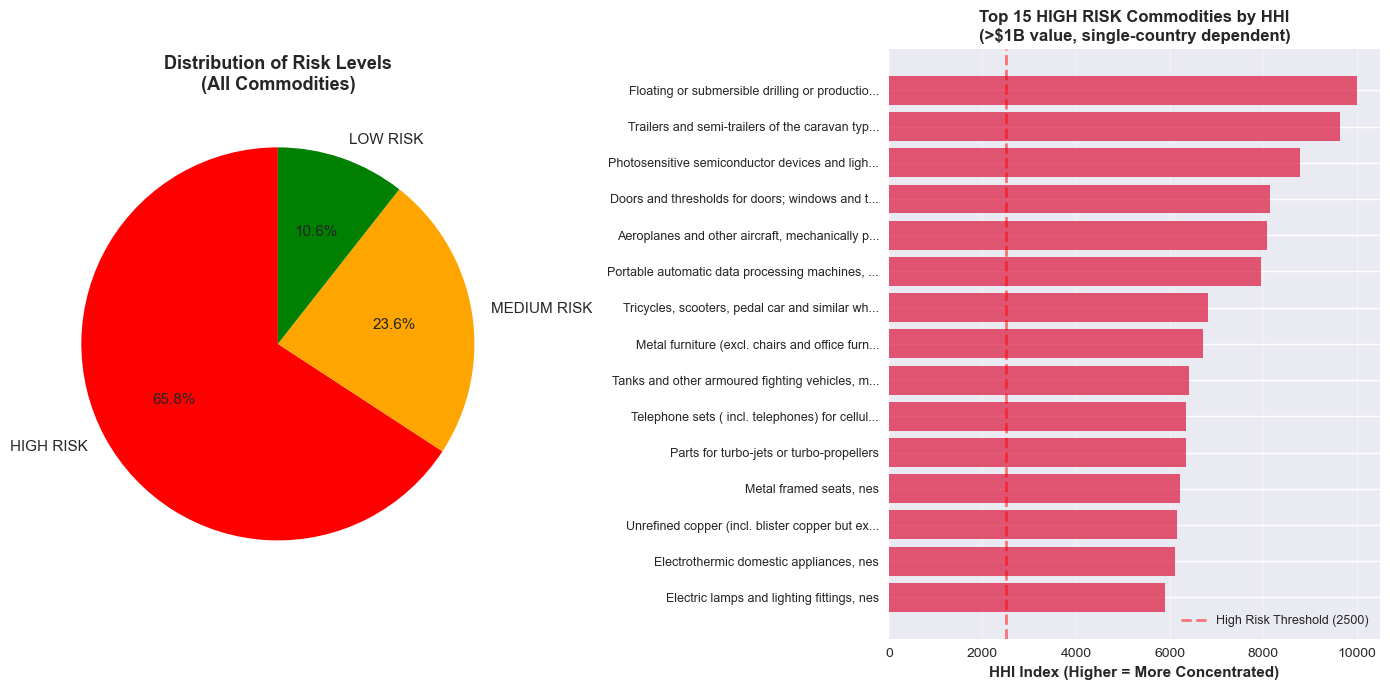


=== TABLE: TOP 15 HIGH-RISK COMMODITIES BY HHI ===



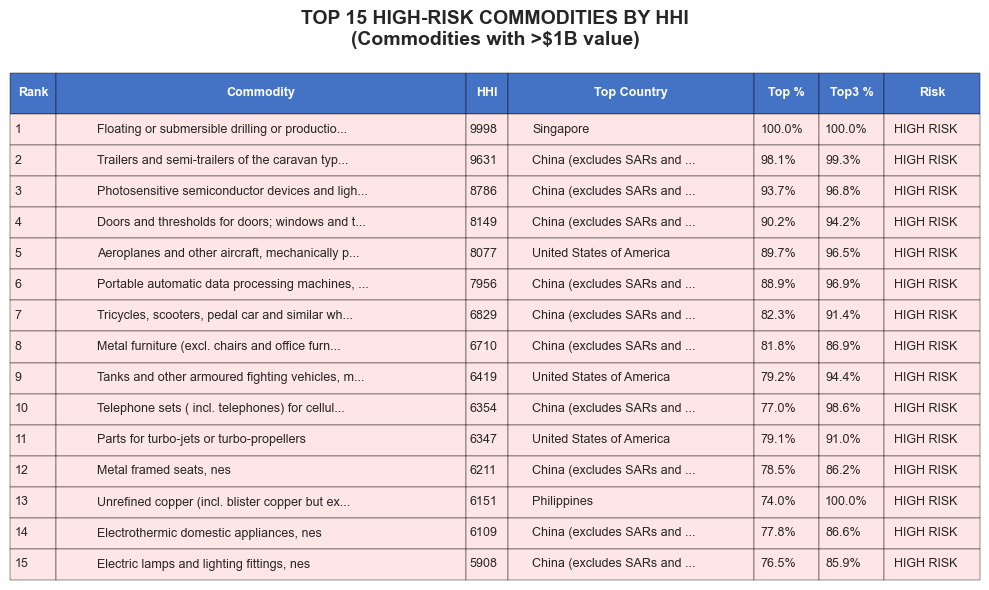

✅ Country Concentration Risk visualizations complete


In [71]:
# Visualization: Country Concentration Risk
print("\n=== VISUALIZING COUNTRY CONCENTRATION RISK ===\n")

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Chart 1: Risk Level Distribution (Pie Chart)
risk_counts = concentration_analysis['risk_level'].value_counts()
colors_risk = {'HIGH RISK': 'red', 'MEDIUM RISK': 'orange', 'LOW RISK': 'green'}
risk_colors = [colors_risk.get(level, 'gray') for level in risk_counts.index]

axes[0].pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%', 
            colors=risk_colors, startangle=90, textprops={'fontsize': 11})
axes[0].set_title('Distribution of Risk Levels\n(All Commodities)', fontsize=13, fontweight='bold')

# Chart 2: Top 15 High-Risk Commodities by HHI (Bar Chart)
high_risk_top15 = concentration_analysis[
    (concentration_analysis['total_value_billions'] >= 1.0) & 
    (concentration_analysis['risk_level'] == 'HIGH RISK')
].sort_values('hhi_index', ascending=False).head(15)

if len(high_risk_top15) > 0:
    high_risk_labels = [desc[:45] + '...' if len(desc) > 47 else desc 
                        for desc in high_risk_top15['commodity_description']]
    axes[1].barh(range(len(high_risk_top15)), high_risk_top15['hhi_index'], color='crimson', alpha=0.7)
    axes[1].set_yticks(range(len(high_risk_top15)))
    axes[1].set_yticklabels(high_risk_labels, fontsize=9)
    axes[1].set_xlabel('HHI Index (Higher = More Concentrated)', fontsize=11, fontweight='bold')
    axes[1].set_title('Top 15 HIGH RISK Commodities by HHI\n(>$1B value, single-country dependent)', 
                     fontsize=12, fontweight='bold')
    axes[1].axvline(x=2500, color='red', linestyle='--', alpha=0.5, linewidth=2, label='High Risk Threshold (2500)')
    axes[1].legend(fontsize=9)
    axes[1].grid(True, alpha=0.3, axis='x')
    axes[1].invert_yaxis()
else:
    axes[1].text(0.5, 0.5, 'No High Risk Commodities\nwith >$1B value', 
                ha='center', va='center', fontsize=12)
    axes[1].set_title('Top 15 HIGH RISK Commodities', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Table: Top 15 High-Risk Commodities Details (Matplotlib Table)
print("\n=== TABLE: TOP 15 HIGH-RISK COMMODITIES BY HHI ===\n")

high_risk_table = concentration_analysis[
    concentration_analysis['total_value_billions'] >= 1.0
].sort_values('hhi_index', ascending=False).head(15).copy()

# Prepare data for table
table_data = []
for idx, (_, row) in enumerate(high_risk_table.iterrows(), 1):
    commodity_name = row['commodity_description'][:45] + '...' if len(row['commodity_description']) > 47 else row['commodity_description']
    top_country_name = row['top_country'][:25] + '...' if len(row['top_country']) > 27 else row['top_country']
    table_data.append([
        str(idx),
        commodity_name,
        f"{row['hhi_index']:.0f}",
        top_country_name,
        f"{row['top_country_share']:.1f}%",
        f"{row['top3_country_share']:.1f}%",
        row['risk_level']
    ])

# Create figure for table
fig_table, ax_table = plt.subplots(figsize=(10, 6))
ax_table.axis('tight')
ax_table.axis('off')

# Define column headers
columns = ['Rank', 'Commodity', 'HHI', 'Top Country', 'Top %', 'Top3 %', 'Risk']

# Create table
table = ax_table.table(cellText=table_data,
                       colLabels=columns,
                       cellLoc='left',
                       loc='center',
                       bbox=[0, 0, 1, 1])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2.5)

# Style header row
for i in range(len(columns)):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')
    table[(0, i)].set_height(0.08)

# Color code rows by risk level
for i in range(1, len(table_data) + 1):
    risk_level = table_data[i-1][6]
    if risk_level == 'HIGH RISK':
        color = '#FFE6E6'  # Light red
    elif risk_level == 'MEDIUM RISK':
        color = '#FFF4E6'  # Light orange
    else:
        color = '#E6F3E6'  # Light green
    
    for j in range(len(columns)):
        table[(i, j)].set_facecolor(color)
        table[(i, j)].set_height(0.06)

# Adjust column widths
table.auto_set_column_width([0, 1, 2, 3, 4, 5, 6])

# Set title
ax_table.set_title('TOP 15 HIGH-RISK COMMODITIES BY HHI\n(Commodities with >$1B value)', 
                   fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("✅ Country Concentration Risk visualizations complete")
print("="*80)


In [72]:
# 2. Commodity Dependence Index Analysis
print("\n=== COMMODITY DEPENDENCE INDEX ANALYSIS ===")
print("Identifying critical commodities and their impact on total imports\n")
print("="*80)

# Calculate total import value
total_import_value = df['valuecif'].sum()

# Calculate commodity dependence (share of total imports)
commodity_dependence = df.groupby('commodity_description').agg({
    'valuecif': 'sum',
    'weight': 'sum',
    'month': 'count'
}).reset_index()

commodity_dependence['dependence_pct'] = (commodity_dependence['valuecif'] / total_import_value * 100)
commodity_dependence['cumulative_pct'] = commodity_dependence['dependence_pct'].cumsum()
commodity_dependence['total_value_billions'] = commodity_dependence['valuecif'] / 1e9

# Sort by value
commodity_dependence = commodity_dependence.sort_values('valuecif', ascending=False)

# Classify dependence levels
def classify_dependence(pct, value_billions):
    if pct >= 5.0 or value_billions >= 40:
        return 'CRITICAL'
    elif pct >= 2.0 or value_billions >= 15:
        return 'HIGH'
    elif pct >= 0.5 or value_billions >= 4:
        return 'MODERATE'
    else:
        return 'LOW'

commodity_dependence['dependence_level'] = commodity_dependence.apply(
    lambda x: classify_dependence(x['dependence_pct'], x['total_value_billions']), axis=1
)

print(f"Total Import Value: ${total_import_value/1e9:.2f} billion")
print(f"Total Commodities: {len(commodity_dependence):,}")
print(f"\nDependence Level Distribution:")
print(commodity_dependence['dependence_level'].value_counts())

print(f"\n{'='*80}\n")
print("TOP 20 COMMODITIES BY DEPENDENCE INDEX")
print("(Critical commodities with highest share of total imports)")
print("-" * 110)
print(f"{'Rank':<6} {'Commodity':<50} {'% of Total':<12} {'Value (B)':<12} {'Cumulative %':<12} {'Level':<12}")
print("-" * 110)

top_20_dependent = commodity_dependence.head(20)
for idx, (_, row) in enumerate(top_20_dependent.iterrows(), 1):
    commodity_name = row['commodity_description'][:48] + '...' if len(row['commodity_description']) > 50 else row['commodity_description']
    print(f"{idx:<6} {commodity_name:<50} {row['dependence_pct']:>10.2f}%  ${row['total_value_billions']:>10.2f}  {row['cumulative_pct']:>11.2f}%  {row['dependence_level']:<12}")

print(f"\n📊 TOP 10 COMMODITIES REPRESENT {commodity_dependence.head(10)['dependence_pct'].sum():.2f}% OF TOTAL IMPORTS")
print(f"📊 TOP 20 COMMODITIES REPRESENT {commodity_dependence.head(20)['dependence_pct'].sum():.2f}% OF TOTAL IMPORTS")

print("\n" + "="*80)
print("\n📊 INTERPRETATION:")
print("  • CRITICAL: ≥5% of total imports OR ≥$40B (if disrupted, major economic impact)")
print("  • HIGH: ≥2% of total imports OR ≥$15B (significant impact if disrupted)")
print("  • MODERATE: ≥0.5% of total imports OR ≥$4B (noticeable impact)")
print("  • LOW: Below these thresholds")
print("="*80)



=== COMMODITY DEPENDENCE INDEX ANALYSIS ===
Identifying critical commodities and their impact on total imports

Total Import Value: $835.62 billion
Total Commodities: 2,897

Dependence Level Distribution:
dependence_level
LOW         2879
MODERATE      12
CRITICAL       4
HIGH           2
Name: count, dtype: int64


TOP 20 COMMODITIES BY DEPENDENCE INDEX
(Critical commodities with highest share of total imports)
--------------------------------------------------------------------------------------------------------------
Rank   Commodity                                          % of Total   Value (B)    Cumulative % Level       
--------------------------------------------------------------------------------------------------------------
1      Petroleum oils & oils obtained from bituminous m...       9.54%  $     79.76        75.63%  CRITICAL    
2      Motor vehicles for the transport of persons (exc...       7.25%  $     60.55        54.52%  CRITICAL    
3      Commodities and tran


=== VISUALIZING COMMODITY DEPENDENCE INDEX ===



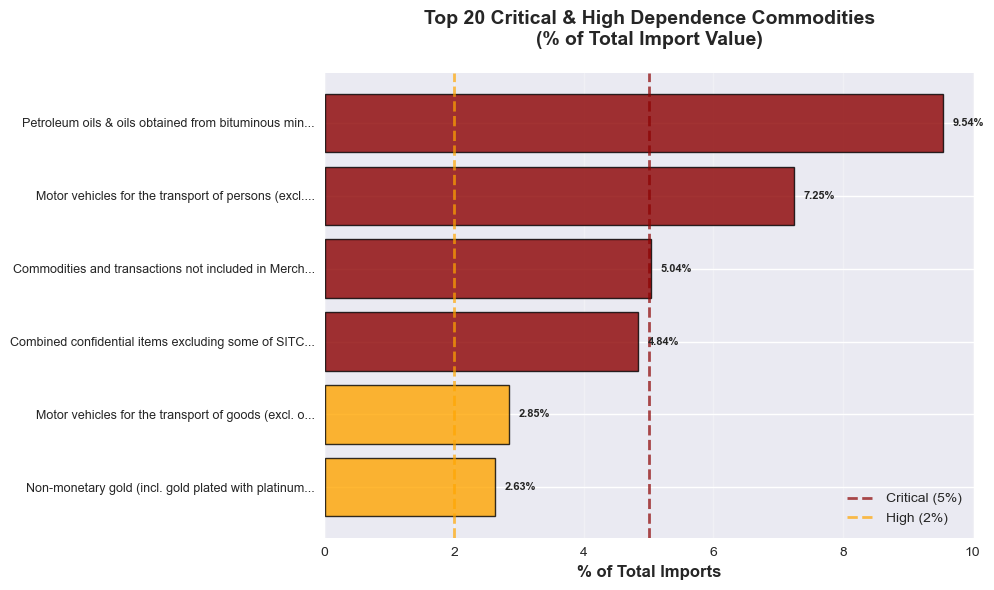


=== TABLE: TOP 20 CRITICAL & HIGH DEPENDENCE COMMODITIES ===



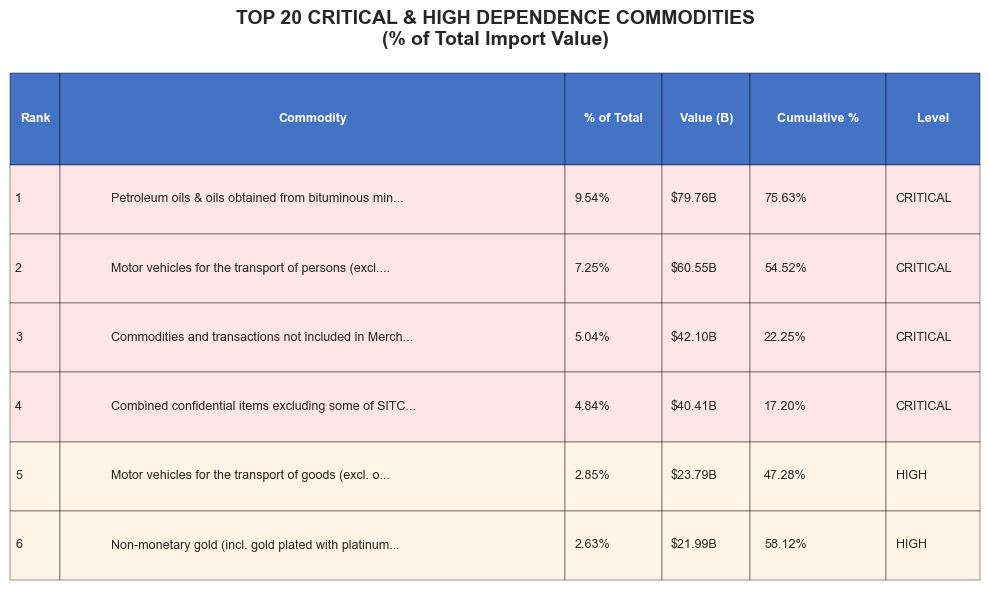

✅ Commodity Dependence Index visualizations complete


In [73]:
# Visualization: Commodity Dependence Index
print("\n=== VISUALIZING COMMODITY DEPENDENCE INDEX ===\n")

# Get Top 20 Critical & High Dependence Commodities
critical_top20 = commodity_dependence[
    commodity_dependence['dependence_level'].isin(['CRITICAL', 'HIGH'])
].sort_values('dependence_pct', ascending=False).head(20)

# Create figure with bar chart
fig, ax = plt.subplots(figsize=(10, 6))

if len(critical_top20) > 0:
    critical_labels = [desc[:50] + '...' if len(desc) > 52 else desc 
                      for desc in critical_top20['commodity_description']]
    colors_dep = {'CRITICAL': 'darkred', 'HIGH': 'orange', 'MODERATE': 'gold', 'LOW': 'lightgreen'}
    bar_colors = [colors_dep.get(level, 'gray') for level in critical_top20['dependence_level']]
    
    bars = ax.barh(range(len(critical_top20)), critical_top20['dependence_pct'], 
                   color=bar_colors, alpha=0.8, edgecolor='black', linewidth=1)
    ax.set_yticks(range(len(critical_top20)))
    ax.set_yticklabels(critical_labels, fontsize=9)
    ax.set_xlabel('% of Total Imports', fontsize=12, fontweight='bold')
    ax.set_title('Top 20 Critical & High Dependence Commodities\n(% of Total Import Value)', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.axvline(x=5, color='darkred', linestyle='--', linewidth=2, alpha=0.7, label='Critical (5%)')
    ax.axvline(x=2, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='High (2%)')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='x')
    ax.invert_yaxis()
    
    # Add value labels
    for i, (idx, row) in enumerate(critical_top20.iterrows()):
        ax.text(row['dependence_pct'] + 0.15, i, f"{row['dependence_pct']:.2f}%",
               va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

# Table: Top 20 Critical & High Dependence Commodities (Matplotlib Table)
print("\n=== TABLE: TOP 20 CRITICAL & HIGH DEPENDENCE COMMODITIES ===\n")

# Prepare data for table
table_data = []
for idx, (_, row) in enumerate(critical_top20.iterrows(), 1):
    commodity_name = row['commodity_description'][:50] + '...' if len(row['commodity_description']) > 52 else row['commodity_description']
    table_data.append([
        str(idx),
        commodity_name,
        f"{row['dependence_pct']:.2f}%",
        f"${row['total_value_billions']:.2f}B",
        f"{row['cumulative_pct']:.2f}%",
        row['dependence_level']
    ])

# Create figure for table
fig_table, ax_table = plt.subplots(figsize=(10, 6))
ax_table.axis('tight')
ax_table.axis('off')

# Define column headers
columns = ['Rank', 'Commodity', '% of Total', 'Value (B)', 'Cumulative %', 'Level']

# Create table
table = ax_table.table(cellText=table_data,
                       colLabels=columns,
                       cellLoc='left',
                       loc='center',
                       bbox=[0, 0, 1, 1])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2.5)

# Style header row
for i in range(len(columns)):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')
    table[(0, i)].set_height(0.08)

# Color code rows by dependence level
for i in range(1, len(table_data) + 1):
    dep_level = table_data[i-1][5]
    if dep_level == 'CRITICAL':
        color = '#FFE6E6'  # Light red
    elif dep_level == 'HIGH':
        color = '#FFF4E6'  # Light orange
    elif dep_level == 'MODERATE':
        color = '#FFFCE6'  # Light yellow
    else:
        color = '#E6F3E6'  # Light green
    
    for j in range(len(columns)):
        table[(i, j)].set_facecolor(color)
        table[(i, j)].set_height(0.06)

# Adjust column widths
table.auto_set_column_width([0, 1, 2, 3, 4, 5])

# Set title
ax_table.set_title('TOP 20 CRITICAL & HIGH DEPENDENCE COMMODITIES\n(% of Total Import Value)', 
                   fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("✅ Commodity Dependence Index visualizations complete")
print("="*80)



=== COMBINED RISK DASHBOARD ===

High-risk commodities (High Concentration + High Dependence)

TOP 20 HIGHEST RISK COMMODITIES
(Combined Concentration + Dependence Risk)
----------------------------------------------------------------------------------------------------------------------------------
Rank   Commodity                                     Risk Score   Overall         HHI      Dep %      Value ($B)  
----------------------------------------------------------------------------------------------------------------------------------
1      Petroleum oils & oils obtained from bitumin...       8.33  EXTREME RISK       1685      9.54%  $     79.76
2      Commodities and transactions not included i...       8.33  EXTREME RISK       1819      5.04%  $     42.10
3      Combined confidential items excluding some ...       8.33  EXTREME RISK       1539      4.84%  $     40.41
4      Motor vehicles for the transport of goods (...       8.33  EXTREME RISK       2907      2.85%  $     23

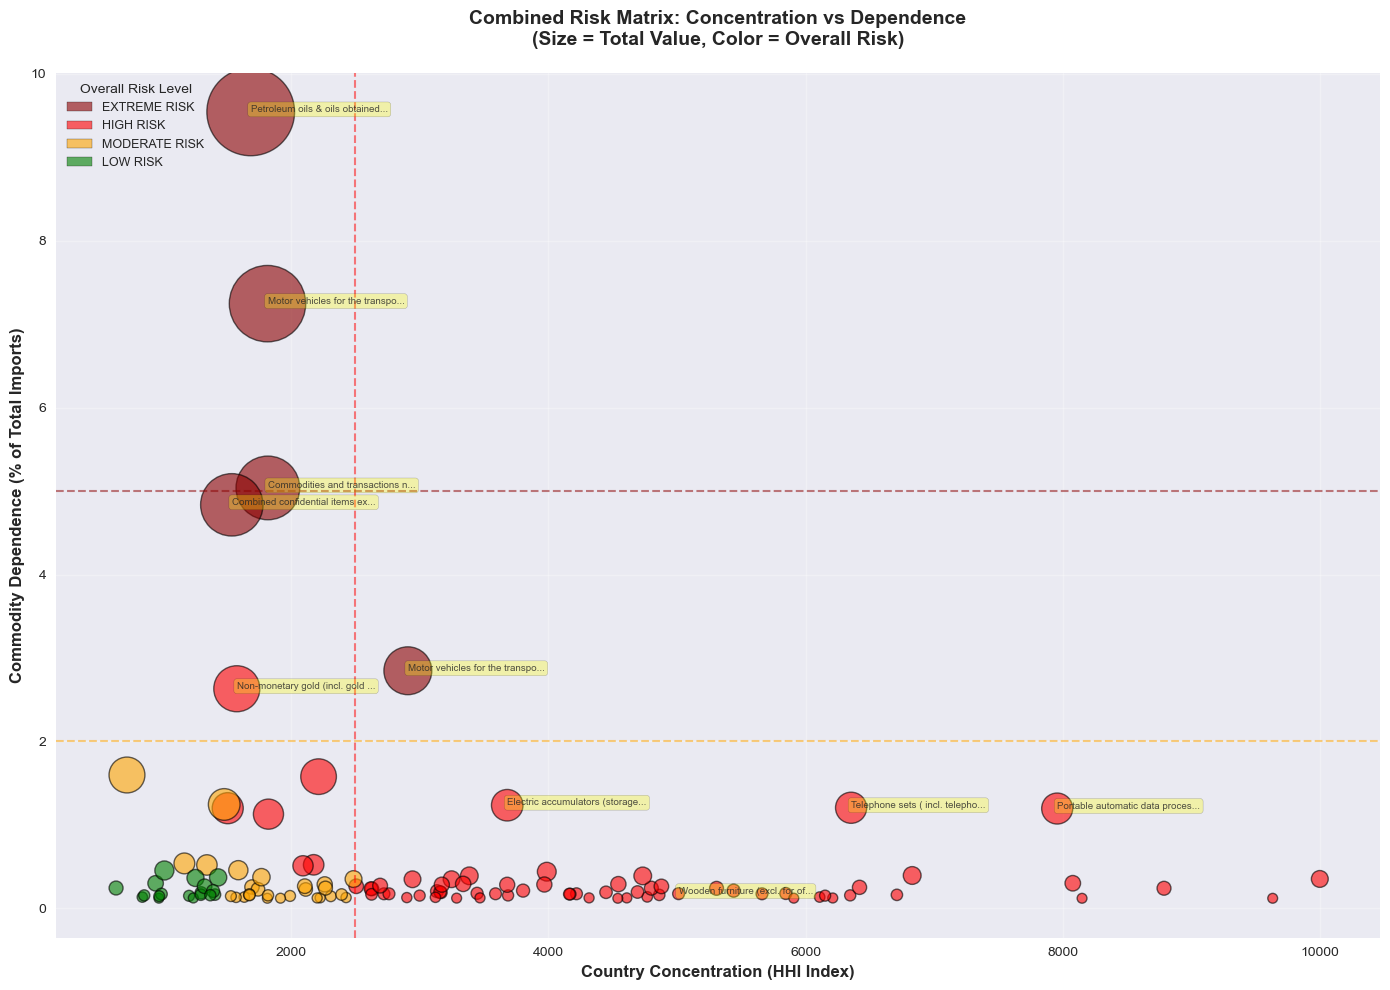

✅ Combined Risk Dashboard complete


In [74]:
# Combined Risk Dashboard: Concentration + Dependence
print("\n=== COMBINED RISK DASHBOARD ===\n")
print("High-risk commodities (High Concentration + High Dependence)\n")

# Merge concentration and dependence analyses
risk_dashboard = concentration_analysis.merge(
    commodity_dependence[['commodity_description', 'dependence_pct', 'dependence_level']],
    on='commodity_description',
    how='inner'
)

# Focus on high-value commodities
risk_dashboard_filtered = risk_dashboard[risk_dashboard['total_value_billions'] >= 1.0].copy()

# Create combined risk score
def calculate_combined_risk(conc_risk, dep_level, hhi, dep_pct):
    """Calculate combined risk score"""
    risk_score = 0
    
    # Concentration risk component
    if conc_risk == 'HIGH RISK':
        risk_score += 3
    elif conc_risk == 'MEDIUM RISK':
        risk_score += 2
    else:
        risk_score += 1
    
    # Dependence risk component
    if dep_level == 'CRITICAL':
        risk_score += 3
    elif dep_level == 'HIGH':
        risk_score += 2
    elif dep_level == 'MODERATE':
        risk_score += 1
    
    # Normalize to 0-10 scale
    return (risk_score / 6) * 10

risk_dashboard_filtered['combined_risk_score'] = risk_dashboard_filtered.apply(
    lambda x: calculate_combined_risk(x['risk_level'], x['dependence_level'], 
                                     x['hhi_index'], x['dependence_pct']), axis=1
)

# Classify overall risk
def classify_combined_risk(score):
    if score >= 7.5:
        return 'EXTREME RISK'
    elif score >= 5.0:
        return 'HIGH RISK'
    elif score >= 3.0:
        return 'MODERATE RISK'
    else:
        return 'LOW RISK'

risk_dashboard_filtered['overall_risk'] = risk_dashboard_filtered['combined_risk_score'].apply(classify_combined_risk)

# Sort by combined risk score
risk_dashboard_filtered = risk_dashboard_filtered.sort_values('combined_risk_score', ascending=False)

print("TOP 20 HIGHEST RISK COMMODITIES")
print("(Combined Concentration + Dependence Risk)")
print("-" * 130)
print(f"{'Rank':<6} {'Commodity':<45} {'Risk Score':<12} {'Overall':<15} {'HHI':<8} {'Dep %':<10} {'Value ($B)':<12}")
print("-" * 130)

top_20_risk = risk_dashboard_filtered.head(20)
for idx, (_, row) in enumerate(top_20_risk.iterrows(), 1):
    commodity_name = row['commodity_description'][:43] + '...' if len(row['commodity_description']) > 45 else row['commodity_description']
    print(f"{idx:<6} {commodity_name:<45} {row['combined_risk_score']:>10.2f}  {row['overall_risk']:<15} {row['hhi_index']:>7.0f}  {row['dependence_pct']:>8.2f}%  ${row['total_value_billions']:>10.2f}")

print(f"\n{'='*80}\n")

# Visualization: Combined Risk Matrix
fig, ax = plt.subplots(figsize=(14, 10))

# Create scatter plot colored by overall risk
colors_overall = {'EXTREME RISK': 'darkred', 'HIGH RISK': 'red', 'MODERATE RISK': 'orange', 'LOW RISK': 'green'}
scatter_colors_overall = [colors_overall.get(level, 'gray') for level in risk_dashboard_filtered['overall_risk']]

scatter = ax.scatter(risk_dashboard_filtered['hhi_index'], 
                    risk_dashboard_filtered['dependence_pct'],
                    s=risk_dashboard_filtered['total_value_billions'] * 50,
                    c=scatter_colors_overall, alpha=0.6, edgecolors='black', linewidth=1)

# Add risk threshold lines
ax.axvline(x=2500, color='red', linestyle='--', alpha=0.5, linewidth=1.5, label='High Concentration (HHI=2500)')
ax.axhline(y=5, color='darkred', linestyle='--', alpha=0.5, linewidth=1.5, label='Critical Dependence (5%)')
ax.axhline(y=2, color='orange', linestyle='--', alpha=0.5, linewidth=1.5, label='High Dependence (2%)')

# Add labels for top risk commodities
for idx, row in risk_dashboard_filtered.head(10).iterrows():
    ax.annotate(row['commodity_description'][:30] + '...' if len(row['commodity_description']) > 30 else row['commodity_description'],
               (row['hhi_index'], row['dependence_pct']),
               fontsize=7, alpha=0.8, 
               bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

ax.set_xlabel('Country Concentration (HHI Index)', fontsize=12, fontweight='bold')
ax.set_ylabel('Commodity Dependence (% of Total Imports)', fontsize=12, fontweight='bold')
ax.set_title('Combined Risk Matrix: Concentration vs Dependence\n(Size = Total Value, Color = Overall Risk)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

# Create custom legend for risk levels
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors_overall[level], alpha=0.6, edgecolor='black') 
                  for level in ['EXTREME RISK', 'HIGH RISK', 'MODERATE RISK', 'LOW RISK']]
ax.legend(legend_elements, ['EXTREME RISK', 'HIGH RISK', 'MODERATE RISK', 'LOW RISK'],
         loc='upper left', fontsize=9, title='Overall Risk Level', title_fontsize=10)

plt.tight_layout()
plt.show()

print("✅ Combined Risk Dashboard complete")
print("="*80)


In [75]:
# 3. Supplier Trend Analysis - Decline in Key Suppliers
print("\n=== SUPPLIER TREND ANALYSIS ===")
print("Identifying declining and emerging suppliers (2024 vs 2025)\n")
print("="*80)

# Calculate country-level imports by year
country_yearly = df.groupby(['country_description', 'year']).agg({
    'valuecif': 'sum'
}).reset_index()

# Pivot to compare years
if len(country_yearly['year'].unique()) >= 2:
    country_pivot = country_yearly.pivot_table(
        index='country_description',
        columns='year',
        values='valuecif',
        fill_value=0
    ).reset_index()
    
    # Get year columns dynamically
    year_cols = [col for col in country_pivot.columns if col != 'country_description']
    if len(year_cols) >= 2:
        country_pivot.columns = ['country'] + [f'value_{int(col)}' for col in year_cols]
        
        # Calculate changes
        country_trends = country_pivot.copy()
        country_trends['value_2024'] = country_trends.get('value_2024', 0)
        country_trends['value_2025'] = country_trends.get('value_2025', 0)
        country_trends['absolute_change'] = country_trends['value_2025'] - country_trends['value_2024']
        country_trends['pct_change'] = (
            (country_trends['value_2025'] - country_trends['value_2024']) / 
            country_trends['value_2024'].replace(0, np.nan) * 100
        ).fillna(0)
        
        # Calculate shares
        total_2024 = country_trends['value_2024'].sum()
        total_2025 = country_trends['value_2025'].sum()
        country_trends['share_2024'] = (country_trends['value_2024'] / total_2024 * 100) if total_2024 > 0 else 0
        country_trends['share_2025'] = (country_trends['value_2025'] / total_2025 * 100) if total_2025 > 0 else 0
        country_trends['share_change'] = country_trends['share_2025'] - country_trends['share_2024']
        
        # Filter meaningful countries
        country_trends_filtered = country_trends[
            (country_trends['value_2024'] > 100_000_000) | 
            (country_trends['value_2025'] > 100_000_000)
        ].sort_values('absolute_change', ascending=True)
        
        print(f"Countries analyzed: {len(country_trends_filtered)}")
        print(f"\nTOP 15 DECLINING SUPPLIERS:\n")
        declining = country_trends_filtered.head(15)
        for idx, (_, row) in enumerate(declining.iterrows(), 1):
            print(f"{idx}. {row['country'][:50]}: ${row['value_2024']/1e9:.2f}B → ${row['value_2025']/1e9:.2f}B ({row['pct_change']:+.1f}%)")
    else:
        print("⚠️  Insufficient year data for trend analysis")
else:
    print("⚠️  Data from only one year - cannot perform trend analysis")
print("="*80)



=== SUPPLIER TREND ANALYSIS ===
Identifying declining and emerging suppliers (2024 vs 2025)

Countries analyzed: 82

TOP 15 DECLINING SUPPLIERS:

1. China (excludes SARs and Taiwan): $124.33B → $84.10B (-32.4%)
2. United States of America: $60.70B → $39.48B (-35.0%)
3. Korea, Republic of (South): $26.31B → $14.98B (-43.0%)
4. Japan: $26.82B → $16.83B (-37.3%)
5. Thailand: $21.39B → $12.81B (-40.1%)
6. No Country Details: $18.24B → $10.33B (-43.3%)
7. Germany: $20.37B → $12.98B (-36.3%)
8. Malaysia: $18.45B → $13.31B (-27.9%)
9. Indonesia: $9.95B → $5.02B (-49.6%)
10. Vietnam: $13.49B → $8.61B (-36.2%)
11. India: $12.33B → $8.63B (-30.0%)
12. Belgium: $4.85B → $1.59B (-67.3%)
13. Taiwan: $10.14B → $6.90B (-32.0%)
14. Italy (includes Holy See and San Marino): $10.37B → $7.40B (-28.7%)
15. United Kingdom, Channel Islands and Isle of Man, n: $9.10B → $6.46B (-28.9%)



=== SUPPLIER TREND ANALYSIS ===
Identifying declining and emerging suppliers (2024 vs 2025)

Countries analyzed: 82


TOP 15 DECLINING SUPPLIERS (2024 → 2025)
(Countries with largest absolute decrease in import value)
--------------------------------------------------------------------------------------------------------------
Rank   Country                             2024 ($B)    2025 ($B)    Change ($B)    % Change     Share Δ   
--------------------------------------------------------------------------------------------------------------
1      China (excludes SARs and Taiwan)    $    124.33  $     84.10  $      -40.23       -32.4%      0.08%
2      United States of America            $     60.70  $     39.48  $      -21.22       -35.0%     -0.43%
3      Korea, Republic of (South)          $     26.31  $     14.98  $      -11.33       -43.0%     -0.82%
4      Japan                               $     26.82  $     16.83  $       -9.99       -37.3%     -0.37%
5      Thailand        

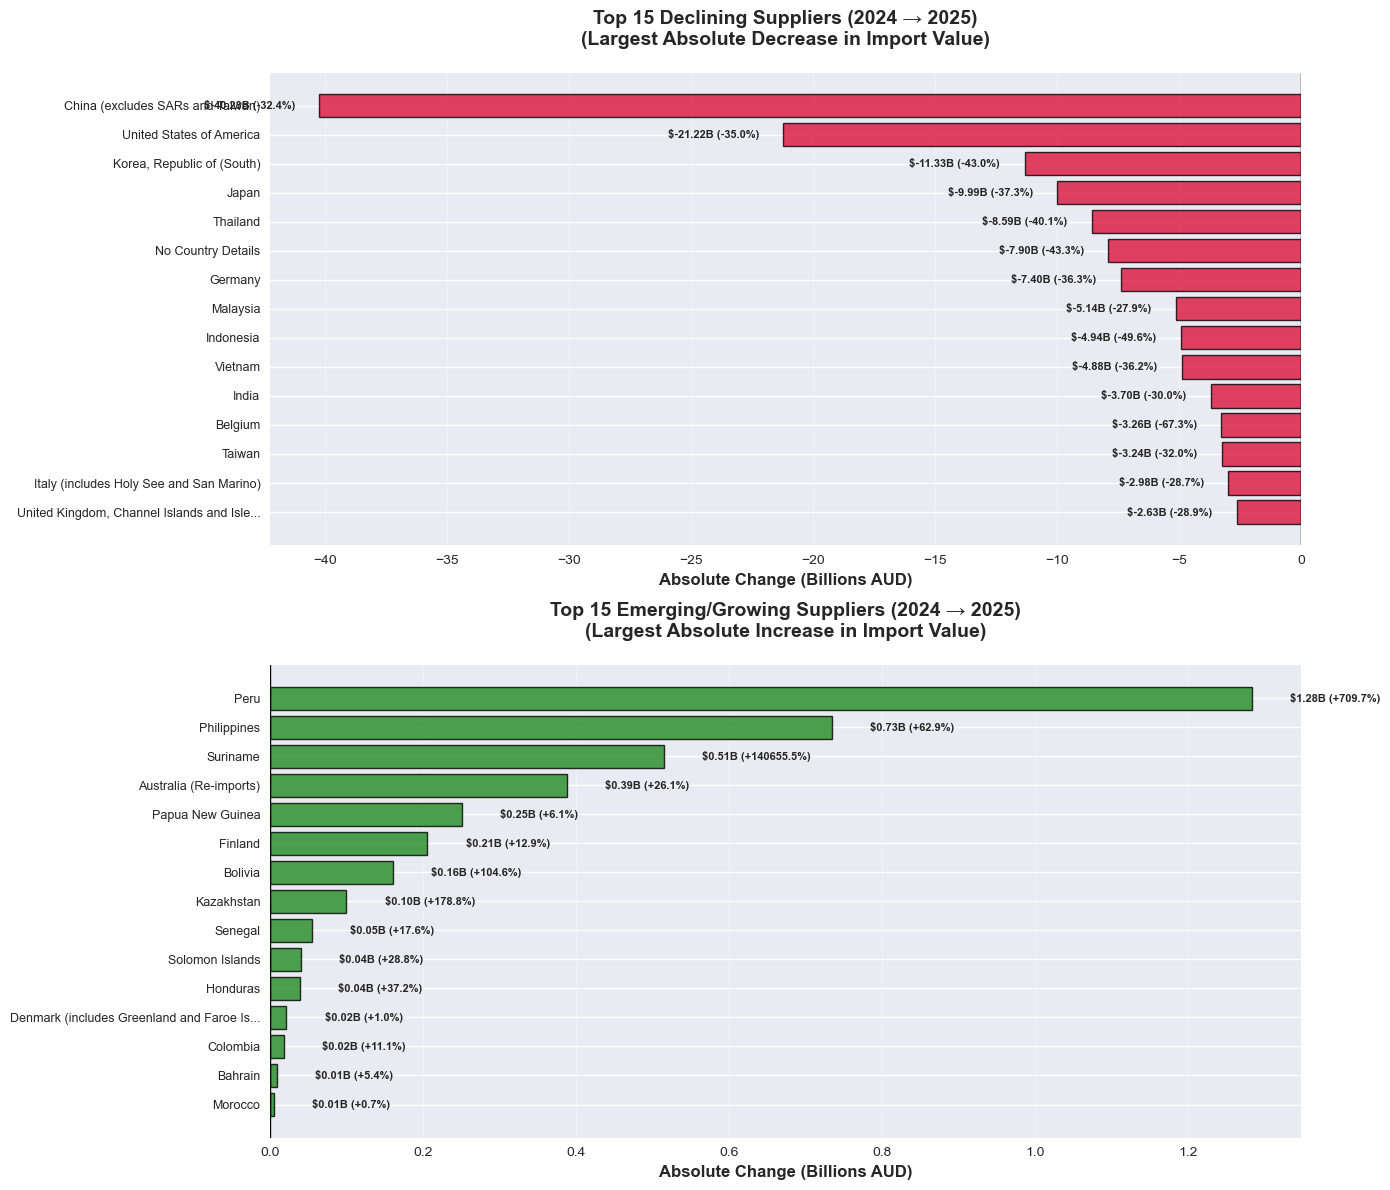

✅ Supplier Trend Analysis visualization complete


In [76]:
# 3. Supplier Trend Analysis - Decline in Key Suppliers
print("\n=== SUPPLIER TREND ANALYSIS ===")
print("Identifying declining and emerging suppliers (2024 vs 2025)\n")
print("="*80)

# Calculate country-level imports by year
country_yearly = df.groupby(['country_description', 'year']).agg({
    'valuecif': 'sum',
    'valuefob': 'sum'
}).reset_index()

# Pivot to compare years
country_pivot = country_yearly.pivot_table(
    index='country_description',
    columns='year',
    values='valuecif',
    fill_value=0
).reset_index()

# Rename columns
if 2024 in country_pivot.columns and 2025 in country_pivot.columns:
    country_pivot.columns = ['country', 'value_2024', 'value_2025']
elif 2024 in country_pivot.columns:
    country_pivot.columns = ['country', 'value_2024']
    country_pivot['value_2025'] = 0
elif 2025 in country_pivot.columns:
    country_pivot.columns = ['country', 'value_2025']
    country_pivot['value_2024'] = 0
else:
    country_pivot.columns = ['country'] + [f'value_{col}' for col in country_pivot.columns[1:]]

# Calculate changes
country_trends = country_pivot.copy()
country_trends['absolute_change'] = country_trends['value_2025'] - country_trends['value_2024']
country_trends['pct_change'] = (
    (country_trends['value_2025'] - country_trends['value_2024']) / 
    country_trends['value_2024'].replace(0, np.nan) * 100
).fillna(0)

# Calculate total for share calculation
total_2024 = country_trends['value_2024'].sum()
total_2025 = country_trends['value_2025'].sum()

country_trends['share_2024'] = (country_trends['value_2024'] / total_2024 * 100) if total_2024 > 0 else 0
country_trends['share_2025'] = (country_trends['value_2025'] / total_2025 * 100) if total_2025 > 0 else 0
country_trends['share_change'] = country_trends['share_2025'] - country_trends['share_2024']

# Filter countries with meaningful value in at least one year (>$100M)
country_trends_filtered = country_trends[
    (country_trends['value_2024'] > 100_000_000) | 
    (country_trends['value_2025'] > 100_000_000)
].copy()

# Sort by absolute change (declining first)
country_trends_filtered = country_trends_filtered.sort_values('absolute_change', ascending=True)

print(f"Countries analyzed: {len(country_trends_filtered)}")
print(f"\n{'='*80}\n")
print("TOP 15 DECLINING SUPPLIERS (2024 → 2025)")
print("(Countries with largest absolute decrease in import value)")
print("-" * 110)
print(f"{'Rank':<6} {'Country':<35} {'2024 ($B)':<12} {'2025 ($B)':<12} {'Change ($B)':<14} {'% Change':<12} {'Share Δ':<10}")
print("-" * 110)

declining = country_trends_filtered.head(15)
for idx, (_, row) in enumerate(declining.iterrows(), 1):
    country_name = row['country'][:33] + '...' if len(row['country']) > 35 else row['country']
    print(f"{idx:<6} {country_name:<35} ${row['value_2024']/1e9:>10.2f}  ${row['value_2025']/1e9:>10.2f}  ${row['absolute_change']/1e9:>12.2f}  {row['pct_change']:>10.1f}%  {row['share_change']:>8.2f}%")

print(f"\n{'='*80}\n")
print("TOP 15 EMERGING/GROWING SUPPLIERS (2024 → 2025)")
print("(Countries with largest absolute increase in import value)")
print("-" * 110)
print(f"{'Rank':<6} {'Country':<35} {'2024 ($B)':<12} {'2025 ($B)':<12} {'Change ($B)':<14} {'% Change':<12} {'Share Δ':<10}")
print("-" * 110)

growing = country_trends_filtered.tail(15).sort_values('absolute_change', ascending=False)
for idx, (_, row) in enumerate(growing.iterrows(), 1):
    country_name = row['country'][:33] + '...' if len(row['country']) > 35 else row['country']
    print(f"{idx:<6} {country_name:<35} ${row['value_2024']/1e9:>10.2f}  ${row['value_2025']/1e9:>10.2f}  ${row['absolute_change']/1e9:>12.2f}  {row['pct_change']:>10.1f}%  {row['share_change']:>8.2f}%")

print("\n" + "="*80)
print("\n📊 INTERPRETATION:")
print("  • DECLINING: Early warning signal - investigate why trade is decreasing")
print("  • EMERGING: Growing relationships - potential diversification opportunities")
print("  • Share Δ: Change in market share percentage points")
print("="*80)

# Visualization: Supplier Trend Analysis
print("\n=== VISUALIZING SUPPLIER TREND ANALYSIS ===\n")

# Get declining and growing suppliers (already calculated above)
declining = country_trends_filtered.head(15).copy()
growing = country_trends_filtered.tail(15).sort_values('absolute_change', ascending=False).copy()

# Create figure with 2 subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Chart 1: Top 15 Declining Suppliers
ax1 = axes[0]
declining_labels = [country[:40] + '...' if len(country) > 42 else country 
                    for country in declining['country']]
y_pos1 = range(len(declining))

# Create horizontal bar chart showing absolute change
bars1 = ax1.barh(y_pos1, declining['absolute_change']/1e9, color='crimson', alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_yticks(y_pos1)
ax1.set_yticklabels(declining_labels, fontsize=9)
ax1.set_xlabel('Absolute Change (Billions AUD)', fontsize=12, fontweight='bold')
ax1.set_title('Top 15 Declining Suppliers (2024 → 2025)\n(Largest Absolute Decrease in Import Value)', 
              fontsize=14, fontweight='bold', pad=20)
ax1.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()

# Add value labels
for i, (idx, row) in enumerate(declining.iterrows()):
    ax1.text(row['absolute_change']/1e9 - 1, i, 
             f"${row['absolute_change']/1e9:.2f}B ({row['pct_change']:+.1f}%)",
             va='center', fontsize=8, fontweight='bold', ha='right')

# Chart 2: Top 15 Emerging/Growing Suppliers
ax2 = axes[1]
growing_labels = [country[:40] + '...' if len(country) > 42 else country 
                  for country in growing['country']]
y_pos2 = range(len(growing))

# Create horizontal bar chart showing absolute change
bars2 = ax2.barh(y_pos2, growing['absolute_change']/1e9, color='forestgreen', alpha=0.8, edgecolor='black', linewidth=1)
ax2.set_yticks(y_pos2)
ax2.set_yticklabels(growing_labels, fontsize=9)
ax2.set_xlabel('Absolute Change (Billions AUD)', fontsize=12, fontweight='bold')
ax2.set_title('Top 15 Emerging/Growing Suppliers (2024 → 2025)\n(Largest Absolute Increase in Import Value)', 
              fontsize=14, fontweight='bold', pad=20)
ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax2.grid(True, alpha=0.3, axis='x')
ax2.invert_yaxis()

# Add value labels
for i, (idx, row) in enumerate(growing.iterrows()):
    ax2.text(row['absolute_change']/1e9 + 0.05, i, 
             f"${row['absolute_change']/1e9:.2f}B ({row['pct_change']:+.1f}%)",
             va='center', fontsize=8, fontweight='bold', ha='left')

plt.tight_layout()
plt.show()

print("✅ Supplier Trend Analysis visualization complete")
print("="*80)


In [77]:
# Key Insights: Market Leaders vs Premium Products
print("\n=== KEY INSIGHTS: MARKET LEADERS vs PREMIUM PRODUCTS ===\n")

print("📊 MARKET LEADERS (High Volume + High Value Industries):")
print("-" * 80)
print("   • These industries have HIGH TOTAL IMPORT VALUE (indicating high volume)")
print("   • They dominate the market by both volume and total value")
print("   • Focus areas: Volume optimization, supply chain efficiency, market share")
if len(market_leaders_df) > 0:
    top_leader = market_leaders_df.iloc[0]
    print(f"   • Top Market Leader: {top_leader['industry_sector']}")
    print(f"     Total Value: ${top_leader['total_value_billions']:.2f} billion")
    print(f"     Value per Tonne: ${top_leader['value_per_tonne']:,.0f}")

print("\n\n💎 PREMIUM PRODUCTS (Low Volume + High Value Industries):")
print("-" * 80)
print("   • These industries have LOWER TOTAL VALUE (low volume) but HIGH VALUE PER TONNE")
print("   • They represent premium, high-value products with specialized markets")
print("   • Focus areas: Quality, branding, margin optimization, niche positioning")
if len(premium_df) > 0:
    top_premium = premium_df.iloc[0]
    print(f"   • Top Premium Product: {top_premium['industry_sector']}")
    print(f"     Value per Tonne: ${top_premium['value_per_tonne']:,.0f}")
    print(f"     Total Value: ${top_premium['total_value_billions']:.2f} billion")

print("\n\n🎯 STRATEGIC IMPLICATIONS:")
print("-" * 80)
print("   • MARKET LEADERS (High Volume + High Value):")
print("     - Focus on volume, operational efficiency, supply chain optimization")
print("     - Market share expansion opportunities")
print("     - Price competitiveness and economies of scale")
print(f"     - {len(market_leaders_df)} industries represent the bulk of import value")
print("\n   • PREMIUM PRODUCTS (Low Volume + High Value):")
print("     - Focus on quality, branding, and margin optimization")
print("     - Niche market positioning and differentiation")
print("     - High value per unit suggests specialized, high-margin products")
print(f"     - {len(premium_df)} industries with premium pricing characteristics")

print("\n\n💡 BUSINESS APPLICATIONS:")
print("-" * 80)
print("   • Use Market Leaders analysis for:")
print("     - Supply chain and logistics planning")
print("     - Volume-based procurement strategies")
print("     - Market entry into high-volume segments")
print("\n   • Use Premium Products analysis for:")
print("     - High-margin product development")
print("     - Niche market opportunities")
print("     - Quality and value-added strategies")

print("\n" + "="*80)



=== KEY INSIGHTS: MARKET LEADERS vs PREMIUM PRODUCTS ===

📊 MARKET LEADERS (High Volume + High Value Industries):
--------------------------------------------------------------------------------
   • These industries have HIGH TOTAL IMPORT VALUE (indicating high volume)
   • They dominate the market by both volume and total value
   • Focus areas: Volume optimization, supply chain efficiency, market share
   • Top Market Leader: Non-Ferrous Metals
     Total Value: $228.94 billion
     Value per Tonne: $21,133


💎 PREMIUM PRODUCTS (Low Volume + High Value Industries):
--------------------------------------------------------------------------------
   • These industries have LOWER TOTAL VALUE (low volume) but HIGH VALUE PER TONNE
   • They represent premium, high-value products with specialized markets
   • Focus areas: Quality, branding, margin optimization, niche positioning
   • Top Premium Product: Animal & Vegetable Oils
     Value per Tonne: $211,008
     Total Value: $0.36 billi

## 5. Transport Mode Analysis


In [78]:
# Transport mode statistics
print("=== TRANSPORT MODE ANALYSIS ===")

mode_stats = df.groupby('mode_description').agg({
    'valuefob': 'sum',
    'valuecif': 'sum',
    'weight': 'sum',
    'quantity': 'sum',
    'month': 'count'
}).reset_index().sort_values('valuefob', ascending=False)

mode_stats['valuefob_pct'] = (mode_stats['valuefob'] / mode_stats['valuefob'].sum()) * 100
mode_stats['weight_pct'] = (mode_stats['weight'] / mode_stats['weight'].sum()) * 100

print(f"\nTransport Mode Summary:")
print(mode_stats.to_string(index=False))

# Average value per tonne by mode
mode_stats['avg_value_per_tonne'] = mode_stats['valuefob'] / mode_stats['weight'].replace(0, np.nan)
print(f"\n\nAverage Value per Tonne by Mode:")
print(mode_stats[['mode_description', 'avg_value_per_tonne']].to_string(index=False))


=== TRANSPORT MODE ANALYSIS ===

Transport Mode Summary:
                               mode_description     valuefob     valuecif       weight     quantity   month  valuefob_pct  weight_pct
                                            SEA 5.926344e+11 6.206205e+11 1.975787e+08 1.967966e+11 2283382     73.923140   98.805477
                                            AIR 1.887449e+11 1.944974e+11 8.214906e+05 4.341451e+09 2193846     23.543375    0.410812
MODE OF TRANSPORT NOT AVAILABLE FOR PUBLICATION 2.029397e+10 2.048210e+10 1.567088e+06 0.000000e+00      40      2.531399    0.783672
                                           POST 1.672054e+07 1.804875e+07 7.781195e+01 8.614765e+05    4311      0.002086    0.000039


Average Value per Tonne by Mode:
                               mode_description  avg_value_per_tonne
                                            SEA          2999.484829
                                            AIR        229759.033132
MODE OF TRANSPORT NOT AVAILABLE

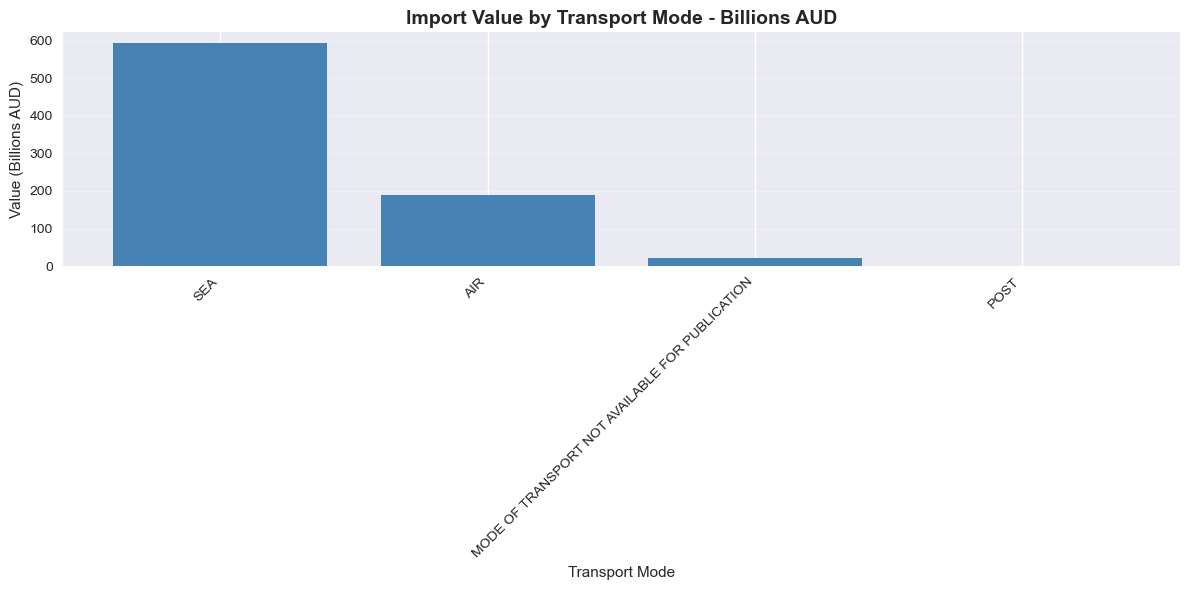

In [79]:
# Visualize transport modes
plt.figure(figsize=(12, 6))

# Value by mode (bar chart)
plt.bar(mode_stats['mode_description'], mode_stats['valuefob']/1e9, color='steelblue')
plt.title('Import Value by Transport Mode - Billions AUD', fontsize=14, fontweight='bold')
plt.ylabel('Value (Billions AUD)')
plt.xlabel('Transport Mode')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


## 4.5 Commodity Trend Analysis

### Year-over-Year Growth Analysis

Analyzing which commodities are growing fastest and which are shrinking between 2024 and 2025.


In [80]:
# Commodity Trend Analysis - Year-over-Year Growth
print("=== COMMODITY TREND ANALYSIS ===")
print("Analyzing year-over-year growth rates by commodity\n")
print("="*80)

# Group by commodity and year to get annual totals
commodity_yearly = df.groupby(['commodity_description', 'year']).agg({
    'valuecif': 'sum',
    'valuefob': 'sum',
    'weight': 'sum',
    'quantity': 'sum'
}).reset_index()

# Pivot to have years as columns
commodity_pivot = commodity_yearly.pivot_table(
    index='commodity_description',
    columns='year',
    values=['valuecif', 'valuefob', 'weight'],
    fill_value=0
).reset_index()

# Flatten column names
commodity_pivot.columns = ['commodity_description', 
                           'valuecif_2024', 'valuecif_2025',
                           'valuefob_2024', 'valuefob_2025',
                           'weight_2024', 'weight_2025']

# Calculate growth rates (only for commodities present in both years)
commodity_trends = commodity_pivot.copy()

# Calculate year-over-year growth rate
commodity_trends['growth_rate_pct'] = (
    (commodity_trends['valuecif_2025'] - commodity_trends['valuecif_2024']) / 
    commodity_trends['valuecif_2024'] * 100
).replace([np.inf, -np.inf], np.nan)

# Calculate absolute change
commodity_trends['absolute_change'] = (
    commodity_trends['valuecif_2025'] - commodity_trends['valuecif_2024']
)

# Calculate total value (average of both years for ranking)
commodity_trends['avg_value'] = (
    (commodity_trends['valuecif_2024'] + commodity_trends['valuecif_2025']) / 2
)

# Filter out commodities that don't exist in both years (or have zero in one year)
commodity_trends_filtered = commodity_trends[
    (commodity_trends['valuecif_2024'] > 0) & 
    (commodity_trends['valuecif_2025'] > 0)
].copy()

# Sort by growth rate
commodity_trends_filtered = commodity_trends_filtered.sort_values('growth_rate_pct', ascending=False)

print(f"Total commodities analyzed: {len(commodity_trends_filtered):,}")
print(f"Commodities present in both years: {len(commodity_trends_filtered):,}")
print(f"\n{'='*80}\n")


=== COMMODITY TREND ANALYSIS ===
Analyzing year-over-year growth rates by commodity

Total commodities analyzed: 2,812
Commodities present in both years: 2,812




In [81]:
# Fastest Growing Commodities
print("=== FASTEST GROWING COMMODITIES (Top 10) ===\n")
print("Ranked by year-over-year growth rate (CIF value)\n")

# Get top 20 fastest growing
top_growing = commodity_trends_filtered.head(10).copy()
top_growing['rank'] = range(1, len(top_growing) + 1)

# Format for display
for idx, row in top_growing.iterrows():
    print(f"Rank {row['rank']}:")
    print(f"  Commodity: {row['commodity_description'][:80]}...")
    print(f"  2024 Value: ${row['valuecif_2024']:,.0f}")
    print(f"  2025 Value: ${row['valuecif_2025']:,.0f}")
    print(f"  Growth Rate: {row['growth_rate_pct']:+.2f}%")
    print(f"  Absolute Change: ${row['absolute_change']:+,.0f}")
    print()

print("="*80)


=== FASTEST GROWING COMMODITIES (Top 10) ===

Ranked by year-over-year growth rate (CIF value)

Rank 1:
  Commodity: Floating or submersible drilling or production platforms...
  2024 Value: $29,772
  2025 Value: $2,939,398,126
  Growth Rate: +9872839.24%
  Absolute Change: $+2,939,368,354

Rank 2:
  Commodity: Unwrought tin alloys...
  2024 Value: $1,324
  2025 Value: $515,490
  Growth Rate: +38833.74%
  Absolute Change: $+514,166

Rank 3:
  Commodity: Copper ores and concentrates...
  2024 Value: $254,113
  2025 Value: $31,070,393
  Growth Rate: +12127.02%
  Absolute Change: $+30,816,281

Rank 4:
  Commodity: Parts of nuclear reactors (excl. elements) nes...
  2024 Value: $1,291
  2025 Value: $109,491
  Growth Rate: +8382.69%
  Absolute Change: $+108,200

Rank 5:
  Commodity: Waste and scrap of alloy steel (excl. stainless steel)...
  2024 Value: $228,369
  2025 Value: $15,566,929
  Growth Rate: +6716.57%
  Absolute Change: $+15,338,560

Rank 6:
  Commodity: Base metal ores and conce

In [82]:
# Fastest Shrinking Commodities
print("=== FASTEST SHRINKING COMMODITIES (Top 10) ===\n")
print("Ranked by year-over-year decline rate (CIF value)\n")

# Get top 20 fastest shrinking (lowest growth rates)
top_shrinking = commodity_trends_filtered.tail(10).copy()
top_shrinking = top_shrinking.sort_values('growth_rate_pct', ascending=True)
top_shrinking['rank'] = range(1, len(top_shrinking) + 1)

# Format for display
for idx, row in top_shrinking.iterrows():
    print(f"Rank {row['rank']}:")
    print(f"  Commodity: {row['commodity_description'][:80]}...")
    print(f"  2024 Value: ${row['valuecif_2024']:,.0f}")
    print(f"  2025 Value: ${row['valuecif_2025']:,.0f}")
    print(f"  Growth Rate: {row['growth_rate_pct']:+.2f}%")
    print(f"  Absolute Change: ${row['absolute_change']:+,.0f}")
    print()

print("="*80)


=== FASTEST SHRINKING COMMODITIES (Top 10) ===

Ranked by year-over-year decline rate (CIF value)

Rank 1:
  Commodity: Chemical wood pulp, dissolving grades...
  2024 Value: $6,647,979
  2025 Value: $3,122
  Growth Rate: -99.95%
  Absolute Change: $-6,644,857

Rank 2:
  Commodity: Slag, dross (excl. granulated slag) scalings and other waste from the manufactur...
  2024 Value: $3,474,047
  2025 Value: $2,594
  Growth Rate: -99.93%
  Absolute Change: $-3,471,453

Rank 3:
  Commodity: Titanium ores and concentrates...
  2024 Value: $11,343,313
  2025 Value: $67,021
  Growth Rate: -99.41%
  Absolute Change: $-11,276,291

Rank 4:
  Commodity: Spacecraft (incl. satellites) and spacecraft launch vehicles...
  2024 Value: $787,868
  2025 Value: $5,387
  Growth Rate: -99.32%
  Absolute Change: $-782,481

Rank 5:
  Commodity: Methyloxirane (propylene oxide)...
  2024 Value: $2,191,509
  2025 Value: $15,448
  Growth Rate: -99.30%
  Absolute Change: $-2,176,061

Rank 6:
  Commodity: Tugs and pus

In [83]:
# Summary Statistics
print("\n=== GROWTH RATE SUMMARY STATISTICS ===\n")

growth_stats = commodity_trends_filtered['growth_rate_pct'].describe()
print("Growth Rate Distribution:")
print(f"  Mean: {growth_stats['mean']:.2f}%")
print(f"  Median: {growth_stats['50%']:.2f}%")
print(f"  Std Dev: {growth_stats['std']:.2f}%")
print(f"  Min: {growth_stats['min']:.2f}%")
print(f"  Max: {growth_stats['max']:.2f}%")

# Count by growth category
growing = len(commodity_trends_filtered[commodity_trends_filtered['growth_rate_pct'] > 0])
shrinking = len(commodity_trends_filtered[commodity_trends_filtered['growth_rate_pct'] < 0])
stable = len(commodity_trends_filtered[commodity_trends_filtered['growth_rate_pct'] == 0])

print(f"\nCommodity Categories:")
print(f"  Growing (>0%): {growing:,} commodities ({growing/len(commodity_trends_filtered)*100:.1f}%)")
print(f"  Shrinking (<0%): {shrinking:,} commodities ({shrinking/len(commodity_trends_filtered)*100:.1f}%)")
print(f"  Stable (=0%): {stable:,} commodities ({stable/len(commodity_trends_filtered)*100:.1f}%)")

# Top growing by absolute value change (for high-value commodities)
print(f"\n=== TOP GROWING BY ABSOLUTE VALUE (Top 10) ===\n")
top_absolute_growth = commodity_trends_filtered.nlargest(10, 'absolute_change')
for idx, row in top_absolute_growth.iterrows():
    print(f"{row['commodity_description'][:70]}...")
    print(f"  Growth: ${row['absolute_change']:+,.0f} ({row['growth_rate_pct']:+.2f}%)")
    print()

print("="*80)



=== GROWTH RATE SUMMARY STATISTICS ===

Growth Rate Distribution:
  Mean: 3515.30%
  Median: -33.33%
  Std Dev: 186182.24%
  Min: -99.95%
  Max: 9872839.24%

Commodity Categories:
  Growing (>0%): 302 commodities (10.7%)
  Shrinking (<0%): 2,510 commodities (89.3%)
  Stable (=0%): 0 commodities (0.0%)

=== TOP GROWING BY ABSOLUTE VALUE (Top 10) ===

Floating or submersible drilling or production platforms...
  Growth: $+2,939,368,354 (+9872839.24%)

Non-monetary gold (incl. gold plated with platinum) unwrought or in se...
  Growth: $+2,192,328,903 (+22.15%)

Unrefined copper (incl. blister copper but excl. cement copper); coppe...
  Growth: $+609,090,224 (+185.38%)

Cruise ships, excursion boats and similar vessels principally designed...
  Growth: $+544,861,609 (+2011.37%)

Units of automatic data processing machines (excl. processing units, i...
  Growth: $+349,709,035 (+96.16%)

Copper mattes and cement copper (precipitated copper)...
  Growth: $+205,193,048 (+422.45%)

Aircraft la


=== VISUALIZING COMMODITY TRENDS ===



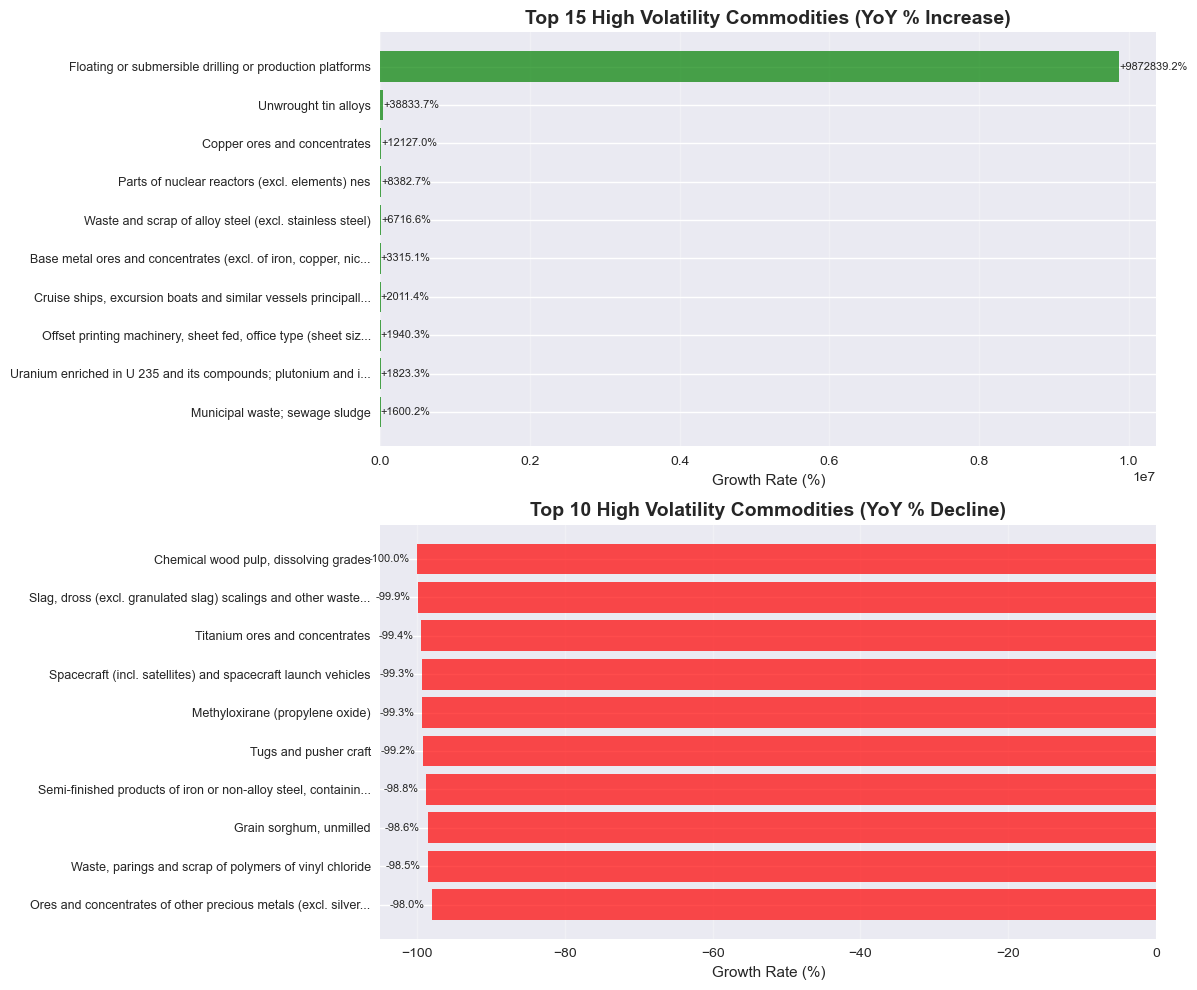

✅ Commodity trend visualization complete


In [84]:
# Visualize Fastest Growing Commodities
print("\n=== VISUALIZING COMMODITY TRENDS ===\n")

# Top 15 fastest growing
top_10_growing = commodity_trends_filtered.head(10).copy()
top_10_growing_labels = [desc[:60] + '...' if len(desc) > 60 else desc 
                         for desc in top_10_growing['commodity_description']]

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Chart 1: Top 15 Fastest Growing (by growth rate %)
ax1 = axes[0]
y_pos = range(len(top_10_growing))
bars = ax1.barh(y_pos, top_10_growing['growth_rate_pct'], color='green', alpha=0.7)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(top_10_growing_labels, fontsize=9)
ax1.set_xlabel('Growth Rate (%)', fontsize=11)
ax1.set_title('Top 15 High Volatility Commodities (YoY % Increase)', 
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()

# Add value labels
for i, (idx, row) in enumerate(top_10_growing.iterrows()):
    ax1.text(row['growth_rate_pct'] + 1, i, f"{row['growth_rate_pct']:+.1f}%",
             va='center', fontsize=8)

# Chart 2: Top 15 Fastest Shrinking (by growth rate %)
top_10_shrinking = commodity_trends_filtered.tail(10).sort_values('growth_rate_pct', ascending=True)
top_10_shrinking_labels = [desc[:60] + '...' if len(desc) > 60 else desc 
                          for desc in top_10_shrinking['commodity_description']]

ax2 = axes[1]
y_pos2 = range(len(top_10_shrinking))
bars2 = ax2.barh(y_pos2, top_10_shrinking['growth_rate_pct'], color='red', alpha=0.7)
ax2.set_yticks(y_pos2)
ax2.set_yticklabels(top_10_shrinking_labels, fontsize=9)
ax2.set_xlabel('Growth Rate (%)', fontsize=11)
ax2.set_title('Top 10 High Volatility Commodities (YoY % Decline)', 
              fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')
ax2.invert_yaxis()

# Add value labels
for i, (idx, row) in enumerate(top_10_shrinking.iterrows()):
    ax2.text(row['growth_rate_pct'] - 1, i, f"{row['growth_rate_pct']:+.1f}%",
             va='center', fontsize=8, ha='right')

plt.tight_layout()
plt.show()

print("✅ Commodity trend visualization complete")



=== TOP GROWING COMMODITIES BY ABSOLUTE VALUE ===/Structural Growth Analysis



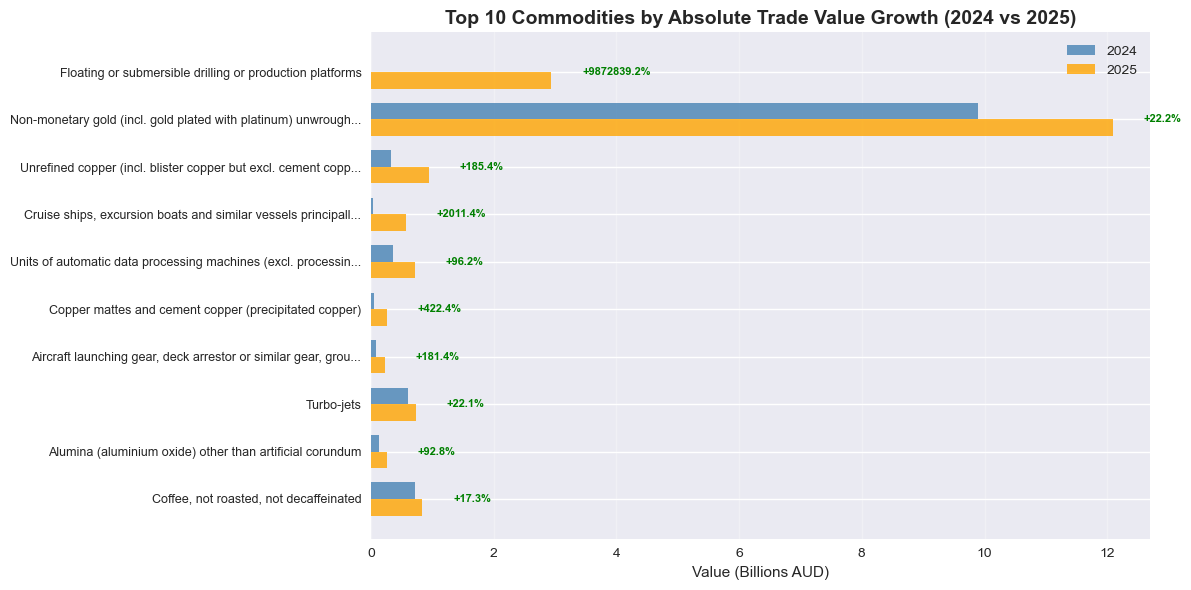

Absolute value growth visualization complete


In [85]:
# Additional Visualization: Top Growing by Absolute Value
print("\n=== TOP GROWING COMMODITIES BY ABSOLUTE VALUE ===/Structural Growth Analysis\n")

# Top 15 by absolute value change
top_10_absolute = commodity_trends_filtered.nlargest(10, 'absolute_change').copy()
top_10_absolute_labels = [desc[:60] + '...' if len(desc) > 60 else desc 
                         for desc in top_10_absolute['commodity_description']]

fig, ax = plt.subplots(figsize=(12, 6))

# Create grouped bar chart showing 2024 vs 2025
x_pos = np.arange(len(top_10_absolute))
width = 0.35

bars1 = ax.barh(x_pos - width/2, top_10_absolute['valuecif_2024']/1e9, width, 
                label='2024', color='steelblue', alpha=0.8)
bars2 = ax.barh(x_pos + width/2, top_10_absolute['valuecif_2025']/1e9, width, 
                label='2025', color='orange', alpha=0.8)

ax.set_yticks(x_pos)
ax.set_yticklabels(top_10_absolute_labels, fontsize=9)
ax.set_xlabel('Value (Billions AUD)', fontsize=11)
ax.set_title('Top 10 Commodities by Absolute Trade Value Growth (2024 vs 2025)', 
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

# Add growth rate annotations
for i, (idx, row) in enumerate(top_10_absolute.iterrows()):
    growth_text = f"{row['growth_rate_pct']:+.1f}%"
    ax.text(row['valuecif_2025']/1e9 + 0.5, i, growth_text,
            va='center', fontsize=8, fontweight='bold',
            color='green' if row['growth_rate_pct'] > 0 else 'red')

plt.tight_layout()
plt.show()

print("Absolute value growth visualization complete")


#### Top Commodities by Absolute Trade Value Growth

##### This chart shows which commodities added the most money to total trade compared to last year. It focuses on the actual dollar increase, not percentages. These commodities have the biggest impact on overall trade and are the most important for business and policy decisions.

#### High Volatility Commodities (YoY % Increase)
##### This chart shows commodities that had very large percentage increases compared to last year. In most cases, this happened because there was little or no trade in the previous year and then a one-off or special purchase occurred this year. These changes reflect irregular or project-based activity, not steady growth.

#### High Volatility Commodities (YoY % Decline)
##### This chart shows commodities where trade almost disappeared compared to last year. This does not mean demand collapsed. Instead, it usually means there was a one-time or special import last year that did not happen again this year.

## 6. Value & Weight Analysis


In [86]:
# FOB vs CIF analysis
print("=== FOB vs CIF ANALYSIS ===")

total_fob = df['valuefob'].sum()
total_cif = df['valuecif'].sum()
total_insurance_freight = total_cif - total_fob

print(f"\nTotal FOB Value: ${total_fob:,.0f}")
print(f"Total CIF Value: ${total_cif:,.0f}")
print(f"Total Insurance & Freight: ${total_insurance_freight:,.0f}")
print(f"Insurance & Freight as % of FOB: {(total_insurance_freight/total_fob)*100:.2f}%")

# Average value per tonne
total_weight = df['weight'].sum()
avg_value_per_tonne_fob = total_fob / total_weight if total_weight > 0 else 0
avg_value_per_tonne_cif = total_cif / total_weight if total_weight > 0 else 0

print(f"\n\nAverage Value per Tonne:")
print(f"  FOB: ${avg_value_per_tonne_fob:,.2f} per tonne")
print(f"  CIF: ${avg_value_per_tonne_cif:,.2f} per tonne")


=== FOB vs CIF ANALYSIS ===

Total FOB Value: $801,689,975,945
Total CIF Value: $835,618,076,095
Total Insurance & Freight: $33,928,100,149
Insurance & Freight as % of FOB: 4.23%


Average Value per Tonne:
  FOB: $4,009.10 per tonne
  CIF: $4,178.77 per tonne


In [87]:
# Value distribution analysis
print("=== VALUE DISTRIBUTION ===")

# Remove zeros for better analysis
df_nonzero = df[df['valuefob'] > 0].copy()

print(f"\nValue Distribution Statistics (excluding zeros):")
print(df_nonzero['valuefob'].describe())

# Percentiles
percentiles = [10, 25, 50, 75, 90, 95, 99]
print(f"\n\nValue Percentiles:")
for p in percentiles:
    val = np.percentile(df_nonzero['valuefob'], p)
    print(f"  {p}th percentile: ${val:,.2f}")


=== VALUE DISTRIBUTION ===

Value Distribution Statistics (excluding zeros):
count    4.441544e+06
mean     1.804980e+05
std      3.764368e+06
min      5.089000e+02
25%      2.795320e+03
50%      9.303075e+03
75%      4.340890e+04
max      2.923070e+09
Name: valuefob, dtype: float64


Value Percentiles:
  10th percentile: $1,420.20
  25th percentile: $2,795.32
  50th percentile: $9,303.08
  75th percentile: $43,408.90
  90th percentile: $176,259.60
  95th percentile: $409,334.85
  99th percentile: $2,128,419.53


In [88]:
# Weight distribution analysis
print("=== WEIGHT DISTRIBUTION ===")

# Remove zeros for better analysis
df_weight_nonzero = df[df['weight'] > 0].copy()

print(f"\nWeight Distribution Statistics (excluding zeros):")
print(df_weight_nonzero['weight'].describe())

# Percentiles
print(f"\n\nWeight Percentiles:")
for p in percentiles:
    val = np.percentile(df_weight_nonzero['weight'], p)
    print(f"  {p}th percentile: {val:,.2f} tonnes")


=== WEIGHT DISTRIBUTION ===

Weight Distribution Statistics (excluding zeros):
count    2.658380e+06
mean     7.522152e+01
std      1.909624e+03
min      1.000000e-05
25%      2.720000e-02
50%      2.998000e-01
75%      7.175883e+00
max      5.304510e+05
Name: weight, dtype: float64


Weight Percentiles:
  10th percentile: 0.00 tonnes
  25th percentile: 0.03 tonnes
  50th percentile: 0.30 tonnes
  75th percentile: 7.18 tonnes
  90th percentile: 36.54 tonnes
  95th percentile: 88.87 tonnes
  99th percentile: 491.16 tonnes


## 7. Seasonal Patterns


=== SEASONAL PATTERNS ===

Average Monthly Values:
 month_number      valuefob      valuecif    weight     quantity month_name
            1 181830.695788 189853.434990 48.150948 48252.552055        Jan
            2 177878.269216 185648.264443 44.181011 45290.091070        Feb
            3 175664.223215 183146.502818 43.799402 41142.386402        Mar
            4 172422.167577 179855.411889 45.942620 44963.097453        Apr
            5 189646.018347 197169.292156 45.748428 46956.810579        May
            6 184949.777407 192212.666843 44.596297 45749.987841        Jun
            7 177249.170162 184474.705055 44.321156 48723.107727        Jul
            8 173634.133220 180869.055413 44.070670 43853.145872        Aug
            9 167914.848313 175349.251951 40.166002 40995.930360        Sep
           10 187628.512732 195741.674627 42.649001 39634.814133        Oct
           11 171197.589138 179019.823318 40.974703 41949.977512        Nov
           12 184012.447859 192188.29

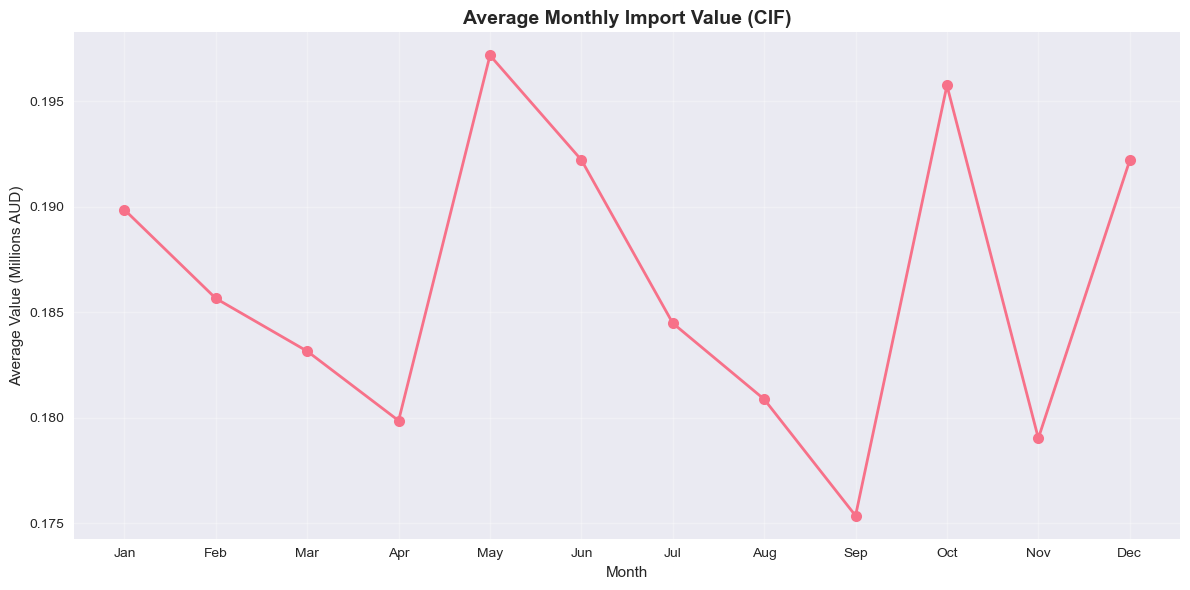

In [89]:
# Seasonal analysis by month
print("=== SEASONAL PATTERNS ===")

monthly_avg = df.groupby('month_number').agg({
    'valuefob': 'mean',
    'valuecif': 'mean',
    'weight': 'mean',
    'quantity': 'mean'
}).reset_index()

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_avg['month_name'] = monthly_avg['month_number'].map(lambda x: month_names[int(x)-1] if pd.notna(x) else '')

print(f"\nAverage Monthly Values:")
print(monthly_avg.to_string(index=False))

# Visualize
plt.figure(figsize=(12, 6))

plt.plot(monthly_avg['month_number'], monthly_avg['valuecif']/1e6, marker='o', linewidth=2, markersize=8)
plt.title('Average Monthly Import Value (CIF)', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Average Value (Millions AUD)')
plt.xticks(monthly_avg['month_number'], monthly_avg['month_name'])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 8. Key Insights & Recommendations


In [90]:
# Generate key insights
print("=== KEY INSIGHTS ===")
print("\n" + "="*60)

# 1. Top country
top_country = country_stats.iloc[0]
print(f"\n1. TOP IMPORT SOURCE:")
print(f"   Country: {top_country['country_description']}")
print(f"   Value: ${top_country['valuecif']:,.0f} ({top_country['valuecif_pct']:.2f}% of total)")

# 2. Top commodity
top_commodity = commodity_stats.iloc[0]
print(f"\n2. TOP IMPORT COMMODITY:")
print(f"   Commodity: {top_commodity['commodity_description']}")
print(f"   Value: ${top_commodity['valuecif']:,.0f} ({top_commodity['valuecif_pct']:.2f}% of total)")

# 3. Dominant transport mode
top_mode = mode_stats.iloc[0]
print(f"\n3. DOMINANT TRANSPORT MODE:")
print(f"   Mode: {top_mode['mode_description']}")
print(f"   Value: ${top_mode['valuefob']:,.0f} ({top_mode['valuefob_pct']:.2f}% of total)")

# 4. Top state
top_state = state_stats.iloc[0]
print(f"\n4. TOP IMPORT STATE:")
print(f"   State: {top_state['state']}")
print(f"   Value: ${top_state['valuecif']:,.0f} ({top_state['valuecif_pct']:.2f}% of total)")

# 5. Year-over-year growth
if len(yearly_stats) > 1:
    yoy_growth = ((yearly_stats.iloc[1]['valuefob'] - yearly_stats.iloc[0]['valuefob']) / yearly_stats.iloc[0]['valuefob']) * 100
    print(f"\n5. YEAR-OVER-YEAR GROWTH:")
    print(f"   Growth Rate: {yoy_growth:+.2f}%")
    print(f"   {yearly_stats.iloc[0]['year']:.0f}: ${yearly_stats.iloc[0]['valuefob']:,.0f}")
    print(f"   {yearly_stats.iloc[1]['year']:.0f}: ${yearly_stats.iloc[1]['valuefob']:,.0f}")

# 6. Concentration analysis
top_5_countries_pct = country_stats.head(5)['valuecif_pct'].sum()
top_10_commodities_pct = commodity_stats.head(10)['valuecif_pct'].sum()
print(f"\n6. MARKET CONCENTRATION:")
print(f"   Top 5 countries: {top_5_countries_pct:.2f}% of total imports (by CIF value)")
print(f"   Top 10 commodities: {top_10_commodities_pct:.2f}% of total imports")

print("\n" + "="*60)
print("\n✅ Analysis complete!")


=== KEY INSIGHTS ===


1. TOP IMPORT SOURCE:
   Country: China (excludes SARs and Taiwan)
   Value: $208,438,318,205 (24.94% of total)

2. TOP IMPORT COMMODITY:
   Commodity: Petroleum oils & oils obtained from bituminous minerals (excl. crude) & prep nes, containing by weight 70% or more of petroleum oils or of oils obtained from bituminous minerals, these oils being the constit of the preparations, excl. waste oils
   Value: $79,755,282,321 (9.54% of total)

3. DOMINANT TRANSPORT MODE:
   Mode: SEA
   Value: $592,634,406,736 (73.92% of total)

4. TOP IMPORT STATE:
   State: New South Wales
   Value: $292,938,897,509 (35.06% of total)

5. YEAR-OVER-YEAR GROWTH:
   Growth Rate: -32.47%
   2024: $478,538,847,318
   2025: $323,151,128,627

6. MARKET CONCENTRATION:
   Top 5 countries: 51.19% of total imports (by CIF value)
   Top 10 commodities: 37.80% of total imports


✅ Analysis complete!


## Summary

This analysis provides comprehensive insights into Australian imports data for 2024-2025:

### Key Areas Analyzed:
1. ✅ **Time Trends** - Monthly patterns and year-over-year growth
2. ✅ **Geographic Distribution** - Top countries, ports, and states
3. ✅ **Commodity Analysis** - Most valuable and heaviest imports
4. ✅ **Transport Modes** - Air vs Sea vs Post distribution
5. ✅ **Value & Weight** - FOB vs CIF, value per tonne
6. ✅ **Seasonal Patterns** - Monthly variations
7. ✅ **Key Insights** - Summary of important findings

### Next Steps:
- Use these insights for strategic decision-making
- Identify opportunities for optimization
- Monitor trends over time
- Focus on high-value segments
